In [1]:
# library(SeuratObject, lib.loc = "/home/kfeng/packages/")
# library(Seurat, lib.loc = "/home/kfeng/packages")
# library(SeuratWrappers, lib.loc = "/home/kfeng/packages")

library(Seurat)
library(Signac)
library(SeuratDisk)
library(dplyr)
library(ggplot2)
library(patchwork)
library(stringr)
library(crayon)
library(ggExtra)
library(future)
library(reshape2)
library(scales)
library(Hmisc)
library(tidyr)
library(tidyverse)

source("/home/vsevim/prj/workflows/catatac/test_caller/guideCallingFunctions_v3.r")
options(future.globals.maxSize= 268435456000) # 250Gb

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘crayon’


The following object is masked from ‘package:ggplot2’:

    %+%



Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summa

In [2]:
# sessionInfo()

R version 4.2.0 (2022-04-22)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/kfeng/anaconda3/envs/r42/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] rstan_2.21.8          StanHeaders_2.26.27   lubridate_1.9.2      
 [4] forcats_1.0.0         purrr_1.0.2           readr_2.1.4          
 [7] tibble_3.2.1          tidyverse_2.0.0       tidyr_1.3.0          
[10] Hmisc_5.1-0           scales_1.2.1          reshape2_1.4.4       
[13] future_1.33.0       

In [3]:
#setwd("~/prj/catatac/scripts")
plan("multicore", workers = 8)
set.seed(1234)
options(digits=2)
stats <- c()

# Load guide-capture data

Define paths etc

In [4]:
#Pass these as parameters
if(!exists("papermill_run")) {
    save_seurat_h5 = "NO"
    run_guide_caller = "YES"
    guide_assignment_method = "HTODEMUX" #"HARD_THRESHOLD"

    # h5_name = "/home/jupyter-ayang/notebooks/cat-atac_pipeline/cond9/secondary/output/seurat/CATATAC_5_CRISPR9_ONLY_SINGLETS_w_GUIDE_CAP.h5seurat"
    # protosp_path = "/home/jupyter-ayang/notebooks/cat-atac_pipeline/cond9/output/resources/protospacers_4set.tsv"
    # library = "CRISPR9"
    # tsv_path = "/home/jupyter-ayang/notebooks/cat-atac_pipeline/cond9/output/tsv/"

    # h5_name = "/home/vsevim/prj/tf/CATATAC_4/analysis/secondary/CRISPR8/seurat/CATATAC_4_CRISPR8_ONLY_SINGLETS.h5seurat"
    # #h5_name = "/home/vsevim/prj/tf/CATATAC_4/analysis/secondary/CRISPR8/seurat/CATATAC_4_CRISPR8_ONLY_SINGLETS_w_GUIDE_CAP.h5seurat"
    # protosp_path = "/home/vsevim/prj/tf/CATATAC_4/analysis/primary/CRISPR8/resources/protospacers_4set.tsv"
    # library = "CRISPR8"
    # tsv_path = "/home/vsevim/prj/tf/CATATAC_4/analysis/primary/CRISPR8/tsv"

    # h5_name = "/home/jupyter-ayang/notebooks/cat-atac_pipeline/K562/secondary/output/seurat/CATATAC_K562_CRISPR_ONLY_SINGLETS.h5seurat"
    # protosp_path = "/home/jupyter-ayang/notebooks/cat-atac_pipeline/K562/primary/output/resources/ps_long_sep.tsv"
    # library = "K562_CRISPR"
    # tsv_path = "/home/jupyter-ayang/notebooks/cat-atac_pipeline/K562/primary/output/tsv"

    h5_name = "/data2/kfeng/deeper_guides_dasatinib/secondary/DASA1/seurat_ngc_testing/CATATAC_CRISPR-DASA1_ONLY_SINGLETS.h5seurat"
    protosp_path = "/data2/kfeng/deeper_guides_dasatinib/dasatinib_primary_01HD/DASA1/resources/ps_dasatinib_screen2.tsv"
    library = "CRISPR-DASA1"
    tsv_path = "/data2/kfeng/deeper_guides_dasatinib/dasatinib_primary_01HD/DASA1/tsv_ngc_testing"


}

In [5]:
h5_w_gcap_name <- sub(".rds", "_w_GUIDE_CAP.rds", h5_name)
# tsv_name <- paste0(tsv_path, "/", library, "_PIVOT.TSV")
# tsv_name <- paste0(tsv_path, "/", library, "_guide_PIVOT.TSV")
tsv_name <- paste0(tsv_path, "/", library, "_PIVOT.TSV")

### Load protospacer file

In [6]:
df_protosp = read.table(protosp_path, header=TRUE, comment.char="")

In [7]:
tfs_w_ntctl    = unique(df_protosp$X.TargetGene)
unselect_ntctl = (tfs_w_ntctl != "NTCTL") & (tfs_w_ntctl != "NTCTRL")
tfs_to_plot    = tfs_w_ntctl[unselect_ntctl]

guides_to_plot  = df_protosp$GuideName
tfs_to_plot
guides_to_plot

[1] "ADNP"    "BRD2"    "CHD2"    "CNOT2"   "GPBP1L1" "HIC2"    "KMT2B"  
 [8] "MNT"     "NTC22"   "NTC28"   "NTC36"   "NTC74"   "NTC82"   "NTC98"  
[15] "PHF6"    "PIAS1"   "PLAGL2"  "PQBP1"   "SIN3A"   "SLTM"    "TSC22D4"
[22] "UBE2L3"  "YEATS4"  "ZBED6"   "ZNF330"  "ZNF669"

[1] "ADNP_1"    "ADNP_2"    "BRD2_1"    "BRD2_2"    "CHD2_1"    "CHD2_2"   
 [7] "CNOT2_1"   "CNOT2_2"   "GPBP1L1_1" "GPBP1L1_2" "HIC2_1"    "HIC2_2"   
[13] "KMT2B_1"   "KMT2B_2"   "MNT_1"     "MNT_2"     "NTC22_1"   "NTC22_2"  
[19] "NTC28_1"   "NTC28_2"   "NTC36_1"   "NTC36_2"   "NTC74_1"   "NTC74_2"  
[25] "NTC82_1"   "NTC82_2"   "NTC98_1"   "NTC98_2"   "PHF6_1"    "PHF6_2"   
[31] "PIAS1_1"   "PIAS1_2"   "PLAGL2_1"  "PLAGL2_2"  "PQBP1_1"   "PQBP1_2"  
[37] "SIN3A_1"   "SIN3A_2"   "SLTM_1"    "SLTM_2"    "TSC22D4_1" "TSC22D4_2"
[43] "UBE2L3_1"  "UBE2L3_2"  "YEATS4_1"  "YEATS4_2"  "ZBED6_1"   "ZBED6_2"  
[49] "ZNF330_1"  "ZNF330_2"  "ZNF669_1"  "ZNF669_2"

In [8]:
tail(df_protosp, 20)


X.TargetGene GuideName value               
33 PLAGL2       PLAGL2_1  GGTGTGGGCGACCGCGCTGA
34 PLAGL2       PLAGL2_2  GCCCCCTCAGGCCCCGGTAG
35 PQBP1        PQBP1_1   TGAAGGCCTCGTTGAGAGA 
36 PQBP1        PQBP1_2   GTATTGGTAACGTTGGGGT 
37 SIN3A        SIN3A_1   AGGCCCCGAGAACGGCGCG 
38 SIN3A        SIN3A_2   TTCCCGGGTAACAGAGAAG 
39 SLTM         SLTM_1    GCCGAGGCTGCCACCGCAC 
40 SLTM         SLTM_2    GAAGAGCAGCGCGCTGCCG 
41 TSC22D4      TSC22D4_1 GAGCCGAGGAGCGGAGACA 
42 TSC22D4      TSC22D4_2 TCCGCTCCTCGGCTCCCCT 
43 UBE2L3       UBE2L3_1  GCCGGCCGCGATGCATTCTG
44 UBE2L3       UBE2L3_2  GCCTAGGCTCCGGATCCCCG
45 YEATS4       YEATS4_1  GAAGGAGGGCGAGTTACTT 
46 YEATS4       YEATS4_2  GAGAGCCACCCCGGAAGAG 
47 ZBED6        ZBED6_1   TAGCGAACACCGGATGTGG 
48 ZBED6        ZBED6_2   CCGGTGTTCGCTAATCTCG 
49 ZNF330       ZNF330_1  ACCAGGACTCCGGGAAAGA 
50 ZNF330       ZNF330_2  AAGAAGGTACTAACAGCCA 
51 ZNF669       ZNF669_1  CTCCCGCGGACCCGACCCG 
52 ZNF669       ZNF669_2  GGACCAGCCGCGGCCACAG

In [9]:
#c("OTP", "MYF6", "MEIS1", "FLI1", "HHEX", "HOXA6", "ELF5", "GBX1", "DPRX", "NTCTL")
##!! tf_list   <- tfs_w_ntctl 

df_guide <- read.table(tsv_name, header = TRUE, sep = "\t", quote = "")
tf_list  <- intersect(guides_to_plot, colnames(df_guide))

guide_counts  <- t(data.matrix(df_guide[,tf_list]))
colnames(guide_counts) <- df_guide$barcode_dash
#guide_counts

Get overlapping cells

In [10]:
N_MIN_GUIDES <- 10
select_overlapping   <-
    df_guide$in_multiome & (df_guide$n_guides >= N_MIN_GUIDES)

overlapping_barcodes <- df_guide[select_overlapping, ]$barcode_dash
overlapping_barcodes <- as.vector(overlapping_barcodes)

overlapping_guide_counts <- guide_counts[, overlapping_barcodes]

n_all_overlapping <- nrow(df_guide[df_guide$in_multiome, ])
paste("Overlapping barcodes w/ min guides =", N_MIN_GUIDES,": ", length(overlapping_barcodes))
paste("Overlapping barcodes w/ min guides =", 1,": ", n_all_overlapping)


[1] "Overlapping barcodes w/ min guides = 10 :  8507"

[1] "Overlapping barcodes w/ min guides = 1 :  8508"

In [11]:
overlapping_guide_counts[1:10]
colnames(df_guide)

[1] 0 0 0 0 0 0 0 0 0 0

[1] "barcode"      "n_guides"     "ADNP_1"       "ADNP_2"       "BRD2_1"      
 [6] "BRD2_2"       "CHD2_1"       "CHD2_2"       "CNOT2_1"      "CNOT2_2"     
[11] "GPBP1L1_1"    "GPBP1L1_2"    "HIC2_1"       "HIC2_2"       "KMT2B_1"     
[16] "KMT2B_2"      "MNT_1"        "MNT_2"        "NTC22_1"      "NTC22_2"     
[21] "NTC28_1"      "NTC28_2"      "NTC36_1"      "NTC36_2"      "NTC74_1"     
[26] "NTC74_2"      "NTC82_1"      "NTC82_2"      "NTC98_1"      "NTC98_2"     
[31] "PHF6_1"       "PHF6_2"       "PIAS1_1"      "PIAS1_2"      "PLAGL2_1"    
[36] "PLAGL2_2"     "PQBP1_1"      "PQBP1_2"      "SIN3A_1"      "SIN3A_2"     
[41] "SLTM_1"       "SLTM_2"       "TSC22D4_1"    "TSC22D4_2"    "UBE2L3_1"    
[46] "UBE2L3_2"     "YEATS4_1"     "YEATS4_2"     "ZBED6_1"      "ZBED6_2"     
[51] "ZNF330_1"     "ZNF330_2"     "ZNF669_1"     "ZNF669_2"     "barcode_dash"
[56] "in_multiome"

In [12]:
head(overlapping_barcodes)

[1] "AAACAGCCAGTTTGTG-1" "AAACAGCCATGGCCCA-1" "AAACAGCCATTCCTCG-1"
[4] "AAACATGCAAACCTTG-1" "AAACATGCACAACAGG-1" "AAACATGCACAGACTC-1"

### Visualize pairs of guides

In [13]:
df_guide_counts = data.frame(t(guide_counts))
colnames(df_guide_counts)
length(colnames(df_guide_counts))

[1] "ADNP_1"    "ADNP_2"    "BRD2_1"    "BRD2_2"    "CHD2_1"    "CHD2_2"   
 [7] "CNOT2_1"   "CNOT2_2"   "GPBP1L1_1" "GPBP1L1_2" "HIC2_1"    "HIC2_2"   
[13] "KMT2B_1"   "KMT2B_2"   "MNT_1"     "MNT_2"     "NTC22_1"   "NTC22_2"  
[19] "NTC28_1"   "NTC28_2"   "NTC36_1"   "NTC36_2"   "NTC74_1"   "NTC74_2"  
[25] "NTC82_1"   "NTC82_2"   "NTC98_1"   "NTC98_2"   "PHF6_1"    "PHF6_2"   
[31] "PIAS1_1"   "PIAS1_2"   "PLAGL2_1"  "PLAGL2_2"  "PQBP1_1"   "PQBP1_2"  
[37] "SIN3A_1"   "SIN3A_2"   "SLTM_1"    "SLTM_2"    "TSC22D4_1" "TSC22D4_2"
[43] "UBE2L3_1"  "UBE2L3_2"  "YEATS4_1"  "YEATS4_2"  "ZBED6_1"   "ZBED6_2"  
[49] "ZNF330_1"  "ZNF330_2"  "ZNF669_1"  "ZNF669_2"

[1] 52

In [14]:
# p1 <- ggplot(df_guide_counts, aes(x=ATRX_3, y=ATRX_4)) +
#     geom_point(size = .2) +
#     scale_y_continuous(trans='log10') +
#     scale_x_continuous(trans='log10')
    
# p1 <- ggExtra::ggMarginal(p1, type = "histogram")
# p1

In [15]:
df_guide_counts

ADNP_1 ADNP_2 BRD2_1 BRD2_2 CHD2_1 CHD2_2 CNOT2_1 CNOT2_2
AAACAGCCAAACTGTT-1 0      0       0      0      0      0     0        0     
AAACAGCCAAAGCGGC-1 0      0       0      0      0      0     0        0     
AAACAGCCAAATATCC-1 0      0       0      0      0      0     0        0     
AAACAGCCAACATAAG-1 0      0      53      0      0      0     0        0     
AAACAGCCAACCCTAA-1 0      0       0      0      2      0     0        0     
AAACAGCCAACCCTCC-1 0      0       0      0      0      0     0        1     
AAACAGCCAACCTGGT-1 0      0       0      0      0      0     0        0     
AAACAGCCAACTAACT-1 0      0       0      0      0      0     0        0     
AAACAGCCAACTAGAA-1 0      0       0      0      0      0     0        0     
AAACAGCCAACTAGGG-1 0      0       0      0      0      0     0        0     
AAACAGCCAAGCCACT-1 0      0       0      0      0      0     0        0     
AAACAGCCAAGCGAGC-1 0      0       0      0      1      0     0        0     
AAACAGCCAAGCGATG-1 0      0       0      0      0      0     0        0     
AAACAGCCAAGCTAAA-1 0      0       0      0      0      0     0        0     
AAACAGCCAAGCTTAT-1 0      0       0      0      1      0     0        0     
AAACAGCCAAGGTCCT-1 0      0       0      0      0      0     0        0     
AAACAGCCAAGTAAGC-1 0      0       0      0      0      0     0        0     
AAACAGCCAAGTGAAC-1 0      0       0      0      0      0     0        0     
AAACAGCCAATAACGA-1 0      0      47      0     34      0     0        0     
AAACAGCCAATAAGCA-1 0      0      35      0     54      0     0        0     
AAACAGCCAATAGCAA-1 0      1       0      0      0      0     0        0     
AAACAGCCAATATGGA-1 0      0       0     46      0     39     0        0     
AAACAGCCAATCATGT-1 0      0       0      0      0      0     0        0     
AAACAGCCAATCGCAC-1 0      0       0      0      0      0     0        0     
AAACAGCCAATTAGGA-1 0      0       0      0      0      0     0        0     
AAACAGCCAATTGAAG-1 0      0       0      0      0      0     0        0     
AAACAGCCACAAACTT-1 0      0       0      0      0      0     0        0     
AAACAGCCACAAGCCT-1 0      0       0      0      0      0     0        0     
AAACAGCCACAATTAC-1 0      0       0      0      0      0     0       42     
AAACAGCCACACAATT-1 0      0       0      0      0      0     0        0     
⋮                  ⋮      ⋮      ⋮      ⋮      ⋮      ⋮      ⋮       ⋮      
TTTGTTGGTTAGGCTA-1   0     0       0    44      17     0     0        0     
TTTGTTGGTTAGGTTG-1   0     0       0     0       0     0     0        0     
TTTGTTGGTTATCCGT-1   0     0       0     0       0     0     0        0     
TTTGTTGGTTCACTGT-1   0     0       0     0       0     0     0        0     
TTTGTTGGTTCCGGGA-1   0     0       0     0       0     0     0        0     
TTTGTTGGTTCCTGTG-1   0    74       0     0     132     0     0        0     
TTTGTTGGTTCGGGAT-1   0     0       0     0       0     0     0        0     
TTTGTTGGTTCGGTAA-1   0     0       0     0       0     0     0        0     
TTTGTTGGTTGAGCCG-1   0     0       0     0       0     0     0        0     
TTTGTTGGTTGCAATG-1   0     0     150     0     128     0     0        0     
TTTGTTGGTTGCACAA-1   0     0       0     0       0     0     0        0     
TTTGTTGGTTGCGGAT-1   0     0       0     0       0    48     0        0     
TTTGTTGGTTGCTGGG-1   0     0       0     0       0     0     0        0     
TTTGTTGGTTGGCCGA-1   0     0       0     0       0     0     0        0     
TTTGTTGGTTGGTTGA-1   0     0       0     0       0     0     0        0     
TTTGTTGGTTGTCATC-1   0     0       0     0       0     0     0        0     
TTTGTTGGTTGTCCAT-1 111     0       0     0       0     0     0       27     
TTTGTTGGTTGTGACA-1   0     0       0     0      23     0     0        0     
TTTGTTGGTTGTTGCT-1   0     0       0     0       0     0     0        0     
TTTGTTGGTTTAAAGC-1   0     0       0     0       0     0     0        0     
TTTGTTGGTTTAGTC

Warning message:
“Removed 3529 rows containing missing values (`geom_point()`).”


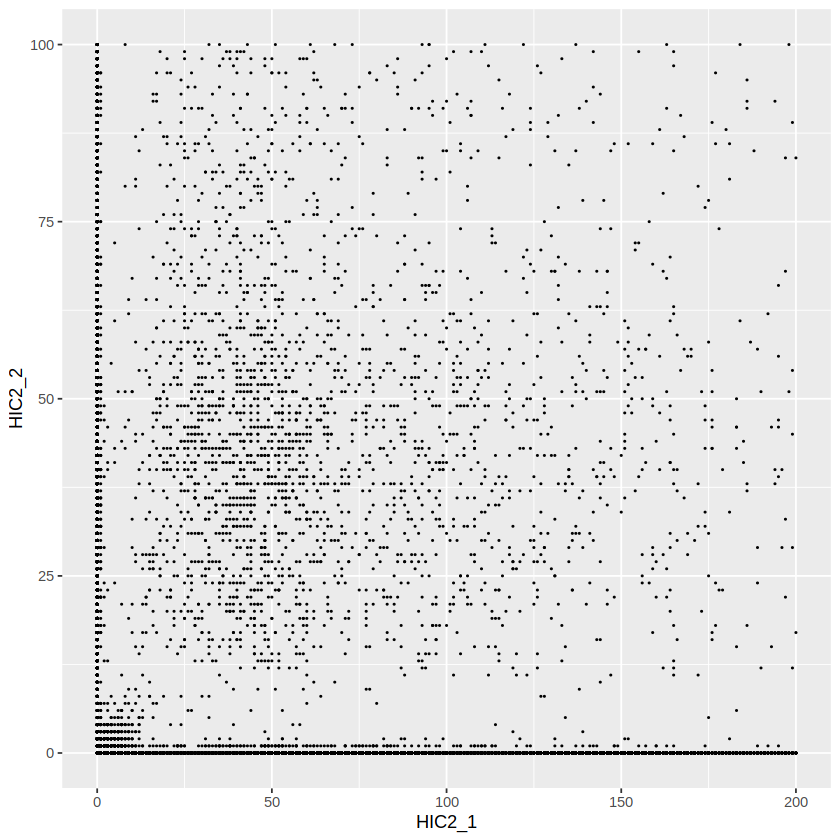

In [16]:
p2 <- ggplot(df_guide_counts, aes(x=HIC2_1, y=HIC2_2)) +
    geom_point(size = .2) +
    xlim(0, 200) +
    ylim(0, 100)
    #scale_y_continuous(trans='log10') +
    #scale_x_continuous(trans='log10')

#p2 <- ggExtra::ggMarginal(p2, type = "histogram")

p2

## Plot stats

Mean #guides per cell 2186

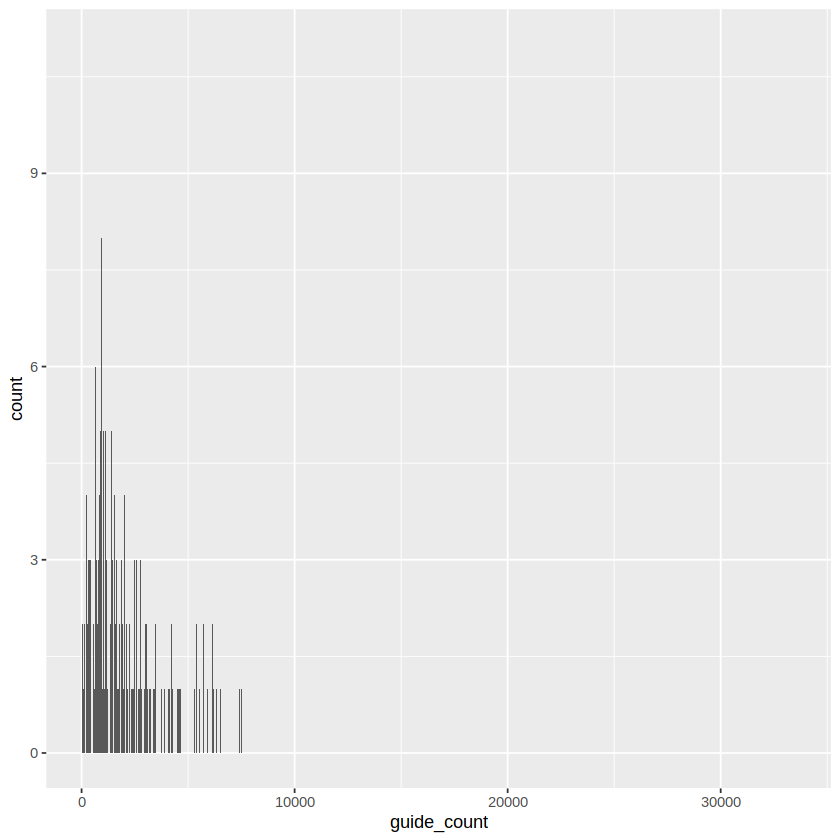

In [17]:
df_guide_counts_per_cell <- data.frame(guide_count=colSums(overlapping_guide_counts))
mean_guides_per_cell = mean(df_guide_counts_per_cell$guide_count)
cat(blue("Mean #guides per cell"), mean_guides_per_cell)

ggplot(df_guide_counts_per_cell, aes(x=guide_count)) +
    geom_histogram(binwidth=1)

No id variables; using all as measure variables



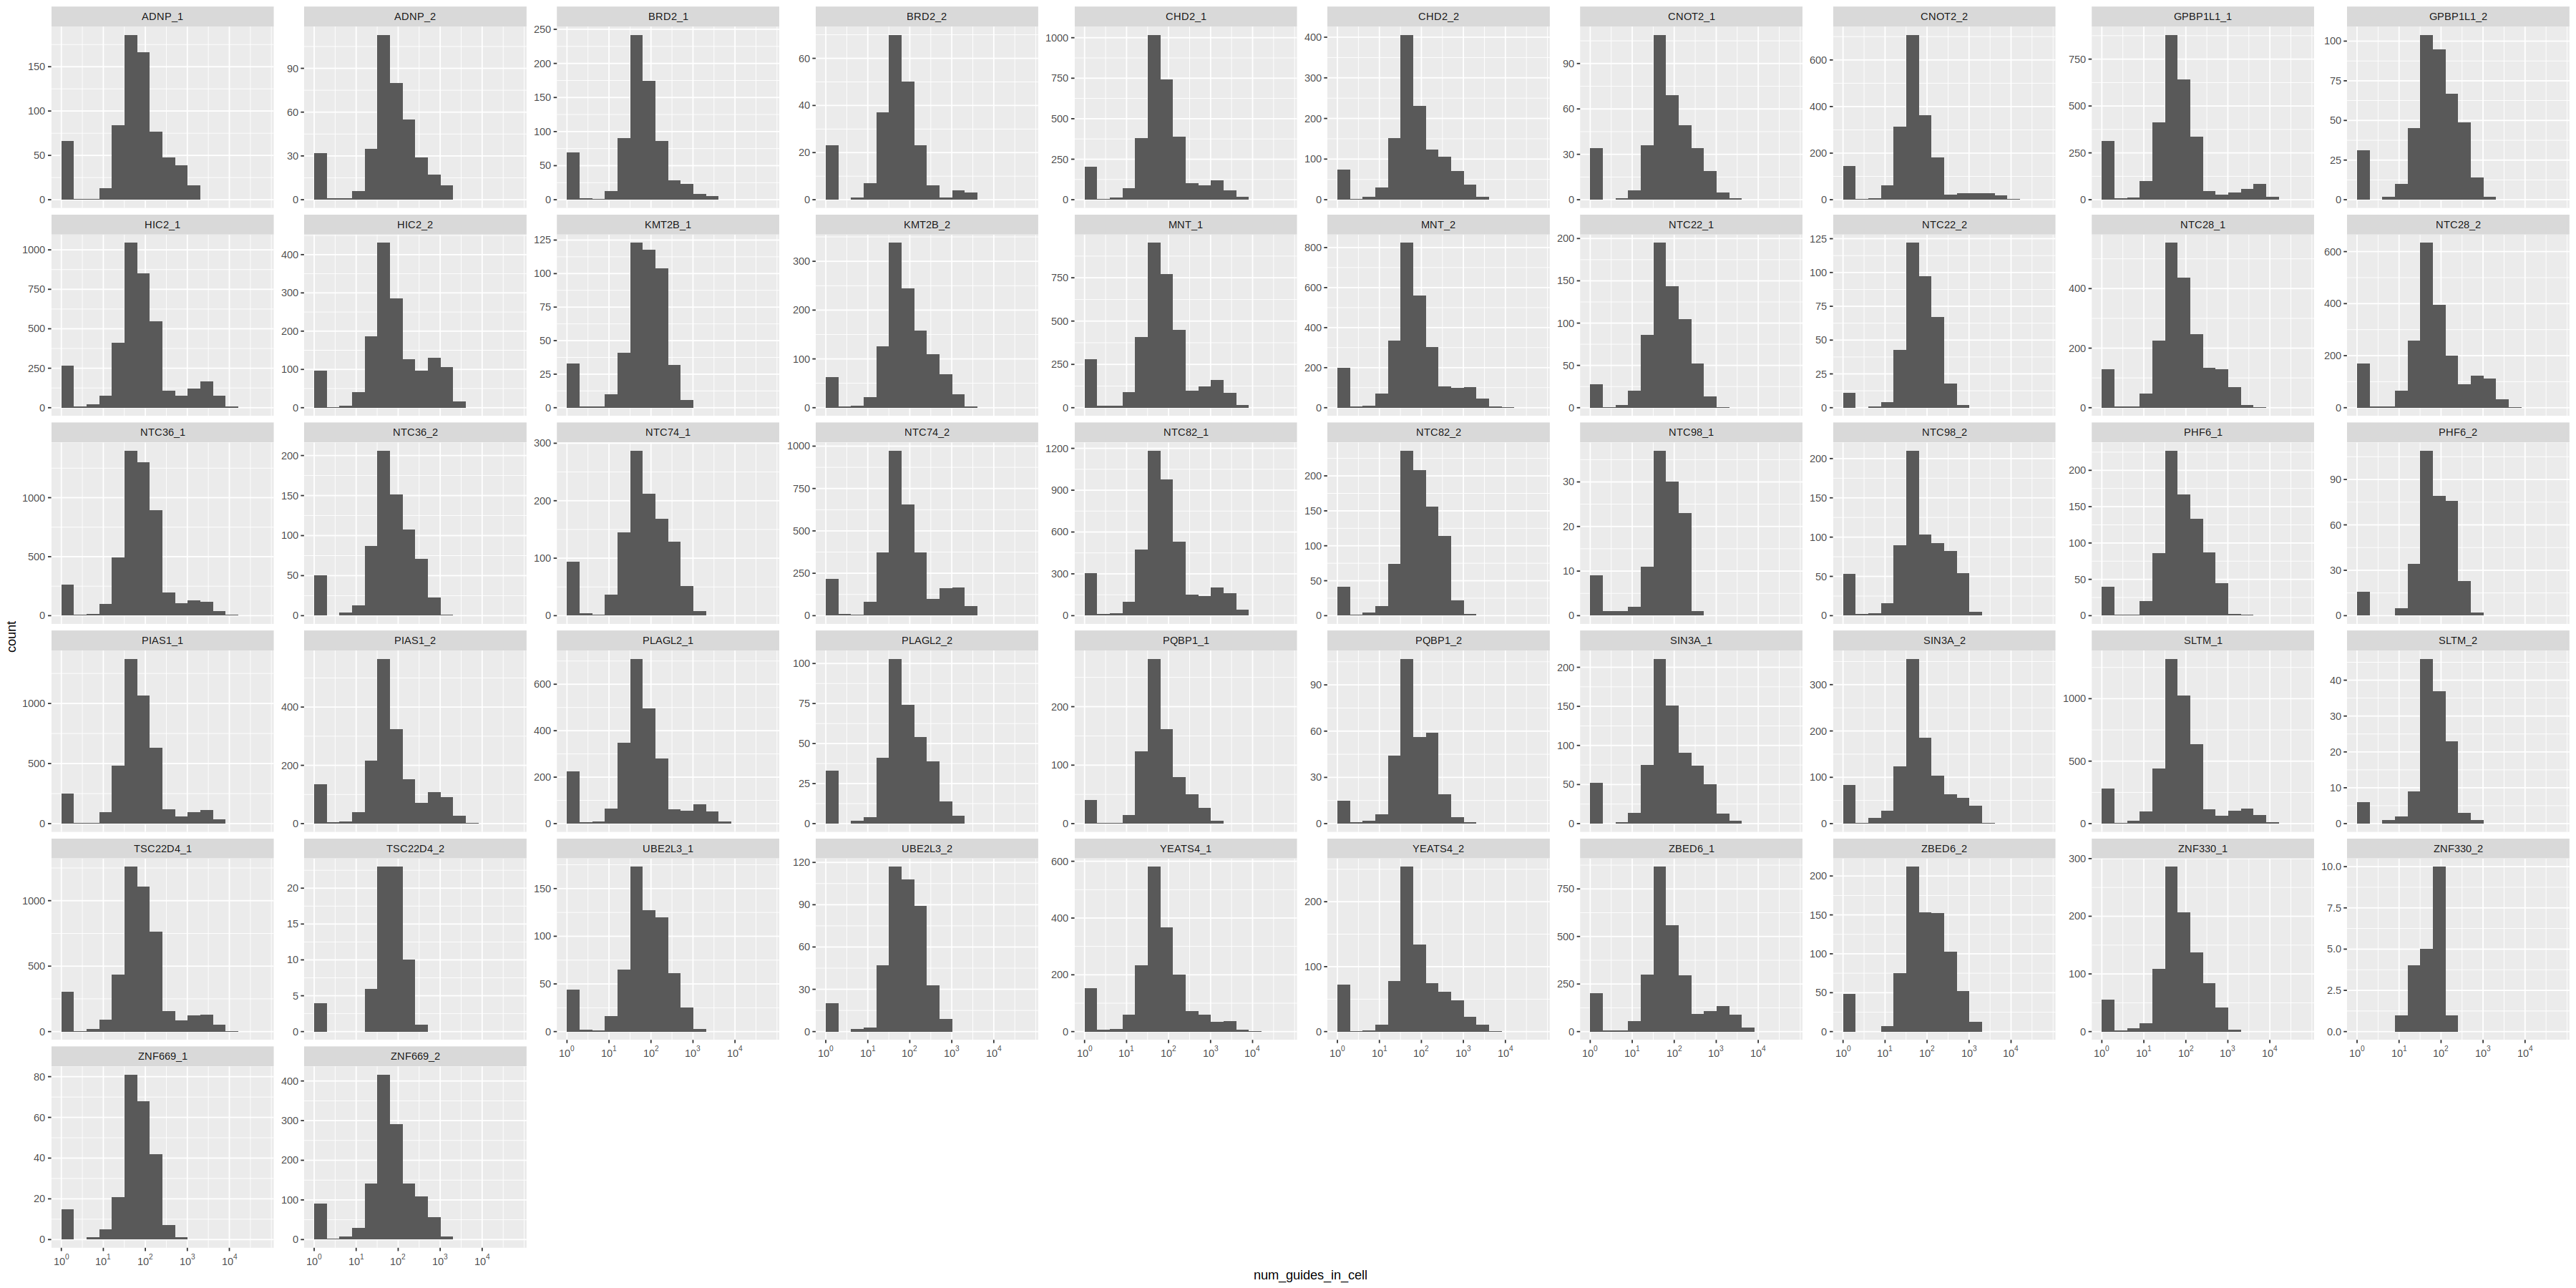

In [18]:
library(reshape2)
library(scales)
df_guide_counts_by_cell <- as.data.frame(t(overlapping_guide_counts))

d <- melt(df_guide_counts_by_cell)
d <- d[d$value > 0,]
colnames(d) = c("guide_name", "num_guides_in_cell")

bin_breaks <- c(1,2,2*2^(1:15))
options(repr.plot.width = 30, repr.plot.height = 15)
ggplot(d, aes(x = num_guides_in_cell)) + 
    geom_histogram(breaks = bin_breaks) +
    labs(y_label="count") +
    scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000)) +
    facet_wrap(~guide_name, scales = "free_y", ncol =  10) 

### Load multiome seurat object

In [19]:
h5_name

[1] "/data2/kfeng/deeper_guides_dasatinib/secondary/DASA1/seurat_ngc_testing/CATATAC_CRISPR-DASA1_ONLY_SINGLETS.h5seurat"

In [20]:
if (!exists("seurat_all")) {
    seurat_all <- readRDS(h5_name)
}
#seurat_all <- LoadH5Seurat(h5_name, verbose=F)

Validating h5Seurat file



In [21]:
# Select cells found in guide capture
seurat     <- subset(seurat_all, cells = overlapping_barcodes)
n_multiome <- length(Cells(seurat_all))

In [22]:
# Add guide data as a new assay independent from RNA & ATAC 
if(! 'guidecapture' %in% names(seurat@assays)) {
    seurat[["guidecapture"]] <- CreateAssayObject(counts = overlapping_guide_counts)
} 


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [23]:
ncol(overlapping_guide_counts)
length(overlapping_barcodes)
nrow(seurat@meta.data)

[1] 8507

[1] 8507

[1] 8507

# Guide assignment

In [24]:
X <- GetAssayData(  seurat[["guidecapture"]], "counts")
model = stan_model("/data2/kfeng/deeper_guides_dasatinib/secondary/customModel.stan" )
guide_list = rownames(seurat[["guidecapture"]])
thresholds = list()
if(run_guide_caller == "YES") {
    for(guide in guide_list) {
        cat("Running", yellow(guide), "\n")
        flush.console()
        # v1 caller
        # fit = callGuides( X, gene = guide, cores = 32)
        # thresholds[[guide]] = getThreshold(fit)
        # seurat@meta.data[guide] = fit$Classifications == 2

        # v2 caller
        ## Load Model Specification
        ## Doing this once outside of function will speed things up 
        ## when calling the function more than once.

        system.time({
            call = callGuides( X, gene = guide, model = model)     
            thresholds[[guide]] = call$Cutoff
            seurat@meta.data[guide] = call$Classifications
        })
    }
    cat(green("Completed"))
}

Running ADNP-1 
Running ADNP-2 
Running BRD2-1 


Warning message in min(which(min_prob_tail > 0.5)):
“no non-missing arguments to min; returning Inf”


Running BRD2-2 


Warning message in min(which(min_prob_tail > 0.5)):
“no non-missing arguments to min; returning Inf”


Running CHD2-1 
Running CHD2-2 
Running CNOT2-1 
Running CNOT2-2 


Warning message in .local(object, ...):
“non-zero return code in optimizing”
Warning message in min(which(min_prob_tail > 0.5)):
“no non-missing arguments to min; returning Inf”


Running GPBP1L1-1 
Running GPBP1L1-2 
Running HIC2-1 
Running HIC2-2 
Running KMT2B-1 
Running KMT2B-2 
Running MNT-1 
Running MNT-2 
Running NTC22-1 
Running NTC22-2 
Running NTC28-1 


Warning message in .local(object, ...):
“non-zero return code in optimizing”


Running NTC28-2 
Running NTC36-1 
Running NTC36-2 
Running NTC74-1 
Running NTC74-2 


Warning message in .local(object, ...):
“non-zero return code in optimizing”


Running NTC82-1 


Warning message in .local(object, ...):
“non-zero return code in optimizing”


Running NTC82-2 
Running NTC98-1 
Running NTC98-2 
Running PHF6-1 
Running PHF6-2 
Running PIAS1-1 
Running PIAS1-2 


Warning message in .local(object, ...):
“non-zero return code in optimizing”


Running PLAGL2-1 
Running PLAGL2-2 
Running PQBP1-1 
Running PQBP1-2 
Running SIN3A-1 
Running SIN3A-2 
Running SLTM-1 
Running SLTM-2 
Running TSC22D4-1 
Running TSC22D4-2 
Running UBE2L3-1 
Running UBE2L3-2 
Running YEATS4-1 
Running YEATS4-2 
Running ZBED6-1 
Running ZBED6-2 
Running ZNF330-1 
Running ZNF330-2 


Warning message in min(which(min_prob_tail > 0.5)):
“no non-missing arguments to min; returning Inf”


Running ZNF669-1 
Running ZNF669-2 


Warning message in min(which(min_prob_tail > 0.5)):
“no non-missing arguments to min; returning Inf”


Completed

In [25]:
head(seurat, 3)

nCount_ATAC nFeature_ATAC nCount_RNA nFeature_RNA
AAACAGCCAGTTTGTG-1 22409       9979           7540      3175        
AAACAGCCATGGCCCA-1 14982       6392          10192      3556        
AAACAGCCATTCCTCG-1  7542       3513           3789      1724        
                   orig.ident                   percent.mt nucleosome_signal
AAACAGCCAGTTTGTG-1 CATATAC_CATATAC_CRISPR-DASA1 12         0.74             
AAACAGCCATGGCCCA-1 CATATAC_CATATAC_CRISPR-DASA1 11         0.54             
AAACAGCCATTCCTCG-1 CATATAC_CATATAC_CRISPR-DASA1 18         0.42             
                   nucleosome_percentile TSS.enrichment TSS.percentile ⋯
AAACAGCCAGTTTGTG-1 0.73                  4.7            0.12           ⋯
AAACAGCCATGGCCCA-1 0.12                  5.7            0.74           ⋯
AAACAGCCATTCCTCG-1 0.00                  5.8            0.80           ⋯
                   UBE2L3-1 UBE2L3-2 YEATS4-1 YEATS4-2 ZBED6-1 ZBED6-2 ZNF330-1
AAACAGCCAGTTTGTG-1 FALSE    FALSE    FALSE    FALSE    FALSE   FALSE    TRUE   
AAACAGCCATGGCCCA-1 FALSE    FALSE     TRUE     TRUE    FALSE    TRUE   FALSE   
AAACAGCCATTCCTCG-1 FALSE    FALSE    FALSE    FALSE    FALSE   FALSE   FALSE   
                   ZNF330-2 ZNF669-1 ZNF669-2
AAACAGCCAGTTTGTG-1 FALSE    FALSE    FALSE   
AAACAGCCATGGCCCA-1 FALSE    FALSE    FALSE   
AAACAGCCATTCCTCG-1 FALSE    FALSE    FALSE

In [26]:
if(run_guide_caller == "YES") {
    table(call$Classifications)
}


FALSE 
 8507 

In [27]:
df_thresholds = as.data.frame(t(data.frame(thresholds)))
colnames(df_thresholds) = c("threshold")
df_thresholds$guide_name = rownames(df_thresholds)
rownames(df_thresholds) =  NULL
head(df_thresholds)


threshold guide_name
1 149       ADNP.1    
2 109       ADNP.2    
3 Inf       BRD2.1    
4 Inf       BRD2.2    
5 206       CHD2.1    
6 108       CHD2.2

In [28]:
#Save the thresholds here !!!!!

if(run_guide_caller == "YES") {
    df_calls = as.data.frame(seurat@meta.data[, guide_list])
    df_calls[, 1:ncol(df_calls)] <- sapply(df_calls[, 1:ncol(df_calls)], as.logical)
    saveRDS(df_calls, paste0(library, "_calls.rds"))
    write.table(df_thresholds, paste0(library, "_thresholds.csv"), quote = F, sep = "\t", row.names = F)
}

# Load the calls from file and visualize

In [29]:
guide_list = rownames(seurat[["guidecapture"]])
#df_calls = readRDS("/data2/kfeng/deeper_guides_dasatinib/secondary/guide_caller_calls/DASA1/DASA1_calls.rds")
df_calls[, 1:ncol(df_calls)] <- sapply(df_calls[, 1:ncol(df_calls)], as.logical)
#df_thresholds = read.table("/data2/kfeng/deeper_guides_dasatinib/secondary/guide_caller_calls/DASA1/DASA1_thresholds.csv", header = T)
df_thresholds$guide_name = gsub("\\.", "-", df_thresholds$guide_name)
#seurat@meta.data = merge(seurat@meta.data, df_calls, by = 0)
head(df_thresholds)

threshold guide_name
1 149       ADNP-1    
2 109       ADNP-2    
3 Inf       BRD2-1    
4 Inf       BRD2-2    
5 206       CHD2-1    
6 108       CHD2-2

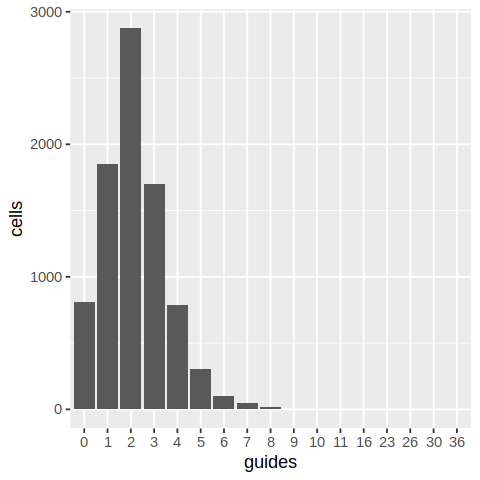

In [30]:
#table(rowSums(df_calls))
options(repr.plot.width = 4, repr.plot.height = 4)
df_dummy = as.data.frame(table(rowSums(df_calls)))
colnames(df_dummy) = c("guides", "cells")
ggplot(df_dummy, aes(x=guides, y=cells)) +
    geom_bar(stat = "identity")

In [31]:
head(df_calls)

ADNP-1 ADNP-2 BRD2-1 BRD2-2 CHD2-1 CHD2-2 CNOT2-1 CNOT2-2
AAACAGCCAGTTTGTG-1 FALSE  FALSE  FALSE  FALSE  FALSE  FALSE  FALSE   FALSE  
AAACAGCCATGGCCCA-1 FALSE  FALSE  FALSE  FALSE  FALSE  FALSE  FALSE   FALSE  
AAACAGCCATTCCTCG-1 FALSE  FALSE  FALSE  FALSE  FALSE  FALSE  FALSE   FALSE  
AAACATGCAAACCTTG-1 FALSE  FALSE  FALSE  FALSE   TRUE  FALSE  FALSE   FALSE  
AAACATGCACAACAGG-1 FALSE  FALSE  FALSE  FALSE  FALSE  FALSE  FALSE   FALSE  
AAACATGCACAGACTC-1 FALSE  FALSE  FALSE  FALSE   TRUE  FALSE  FALSE   FALSE  
                   GPBP1L1-1 GPBP1L1-2 ⋯ UBE2L3-1 UBE2L3-2 YEATS4-1 YEATS4-2
AAACAGCCAGTTTGTG-1 FALSE     FALSE     ⋯ FALSE    FALSE    FALSE    FALSE   
AAACAGCCATGGCCCA-1 FALSE     FALSE     ⋯ FALSE    FALSE     TRUE     TRUE   
AAACAGCCATTCCTCG-1 FALSE     FALSE     ⋯ FALSE    FALSE    FALSE    FALSE   
AAACATGCAAACCTTG-1 FALSE     FALSE     ⋯ FALSE    FALSE    FALSE     TRUE   
AAACATGCACAACAGG-1 FALSE     FALSE     ⋯ FALSE    FALSE    FALSE    FALSE   
AAACATGCACAGACTC-1 FALSE     FALSE     ⋯ FALSE    FALSE    FALSE    FALSE   
                   ZBED6-1 ZBED6-2 ZNF330-1 ZNF330-2 ZNF669-1 ZNF669-2
AAACAGCCAGTTTGTG-1 FALSE   FALSE    TRUE    FALSE    FALSE    FALSE   
AAACAGCCATGGCCCA-1 FALSE    TRUE   FALSE    FALSE    FALSE    FALSE   
AAACAGCCATTCCTCG-1 FALSE   FALSE   FALSE    FALSE    FALSE    FALSE   
AAACATGCAAACCTTG-1 FALSE   FALSE   FALSE    FALSE    FALSE    FALSE   
AAACATGCACAACAGG-1 FALSE   FALSE   FALSE    FALSE    FALSE    FALSE   
AAACATGCACAGACTC-1 FALSE   FALSE   FALSE    FALSE    FALSE    FALSE

In [32]:
gene_names = unique(str_split_fixed(df_protosp$Gene, "_", 2)[,1])
gene_names = df_protosp$X.TargetGene

In [33]:
# guide = "ATRX-3"
# options(repr.plot.width = 20, repr.plot.height = 20)
# select_guide_positives = seurat@meta.data[, guide] == TRUE
# cells = rownames(seurat@meta.data[select_guide_positives, guide])
# Idents(seurat) = paste0(guide, "-neg")
# Idents(seurat, cells = cells) = paste0(guide, "-pos")

# #seurat_subset = subset(seurat, cells = cells)
# #Idents(seurat) <- seurat@meta.data[, guide]
# VlnPlot(seurat, features = gene_names)

In [34]:
#table(rowSums(df_calls[,c('ATRX-4', 'ATRX-3')]))

# Viz gene expression

In [35]:
gene_targets = unique(gene_names[! grepl('NTCTL', gene_names)])
gene_targets

[1] "ADNP"    "BRD2"    "CHD2"    "CNOT2"   "GPBP1L1" "HIC2"    "KMT2B"  
 [8] "MNT"     "NTC22"   "NTC28"   "NTC36"   "NTC74"   "NTC82"   "NTC98"  
[15] "PHF6"    "PIAS1"   "PLAGL2"  "PQBP1"   "SIN3A"   "SLTM"    "TSC22D4"
[22] "UBE2L3"  "YEATS4"  "ZBED6"   "ZNF330"  "ZNF669"

Warning message in FetchData.Seurat(object = object, vars = c(dims, "ident", features), :
“The following requested variables were not found: NTC22, NTC28, NTC36, NTC74, NTC82, NTC98”


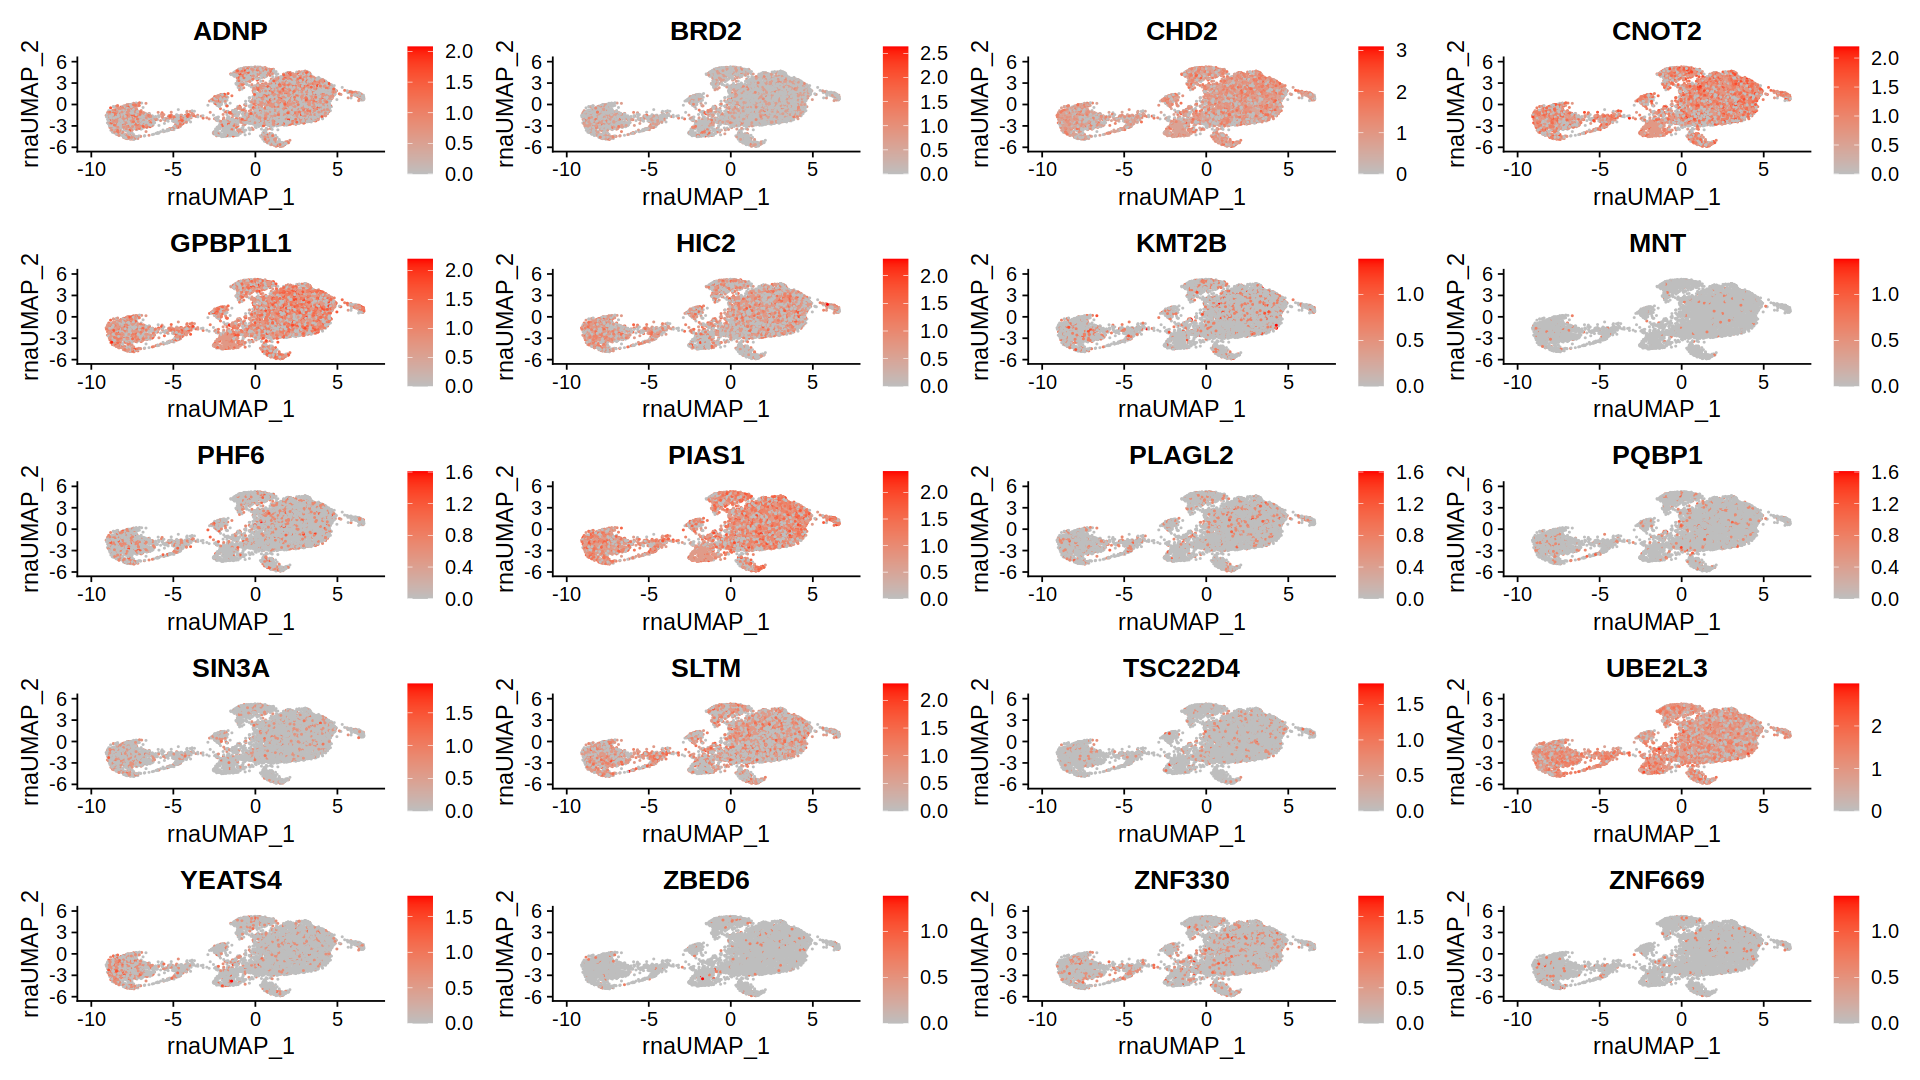

In [36]:
options(repr.plot.width = 16, repr.plot.height = 9)
FeaturePlot(
    seurat,
    features = gene_targets,
    reduction = 'umap.rna',
    cols = c("grey", "red")
) 

# Visualize

In [37]:
df_thresholds_dummy = df_thresholds
select_inf = df_thresholds_dummy$threshold == Inf
df_thresholds_dummy[select_inf, 'threshold'] = NA


In [38]:
head(df_thresholds_dummy)
head(d)

threshold guide_name
1 149       ADNP-1    
2 109       ADNP-2    
3  NA       BRD2-1    
4  NA       BRD2-2    
5 206       CHD2-1    
6 108       CHD2-2

guide_name num_guides_in_cell
28 ADNP_1      82               
30 ADNP_1     122               
46 ADNP_1      34               
53 ADNP_1      18               
59 ADNP_1     258               
64 ADNP_1     127

No id variables; using all as measure variables



Warning message:
“Removed 5 rows containing missing values (`geom_vline()`).”


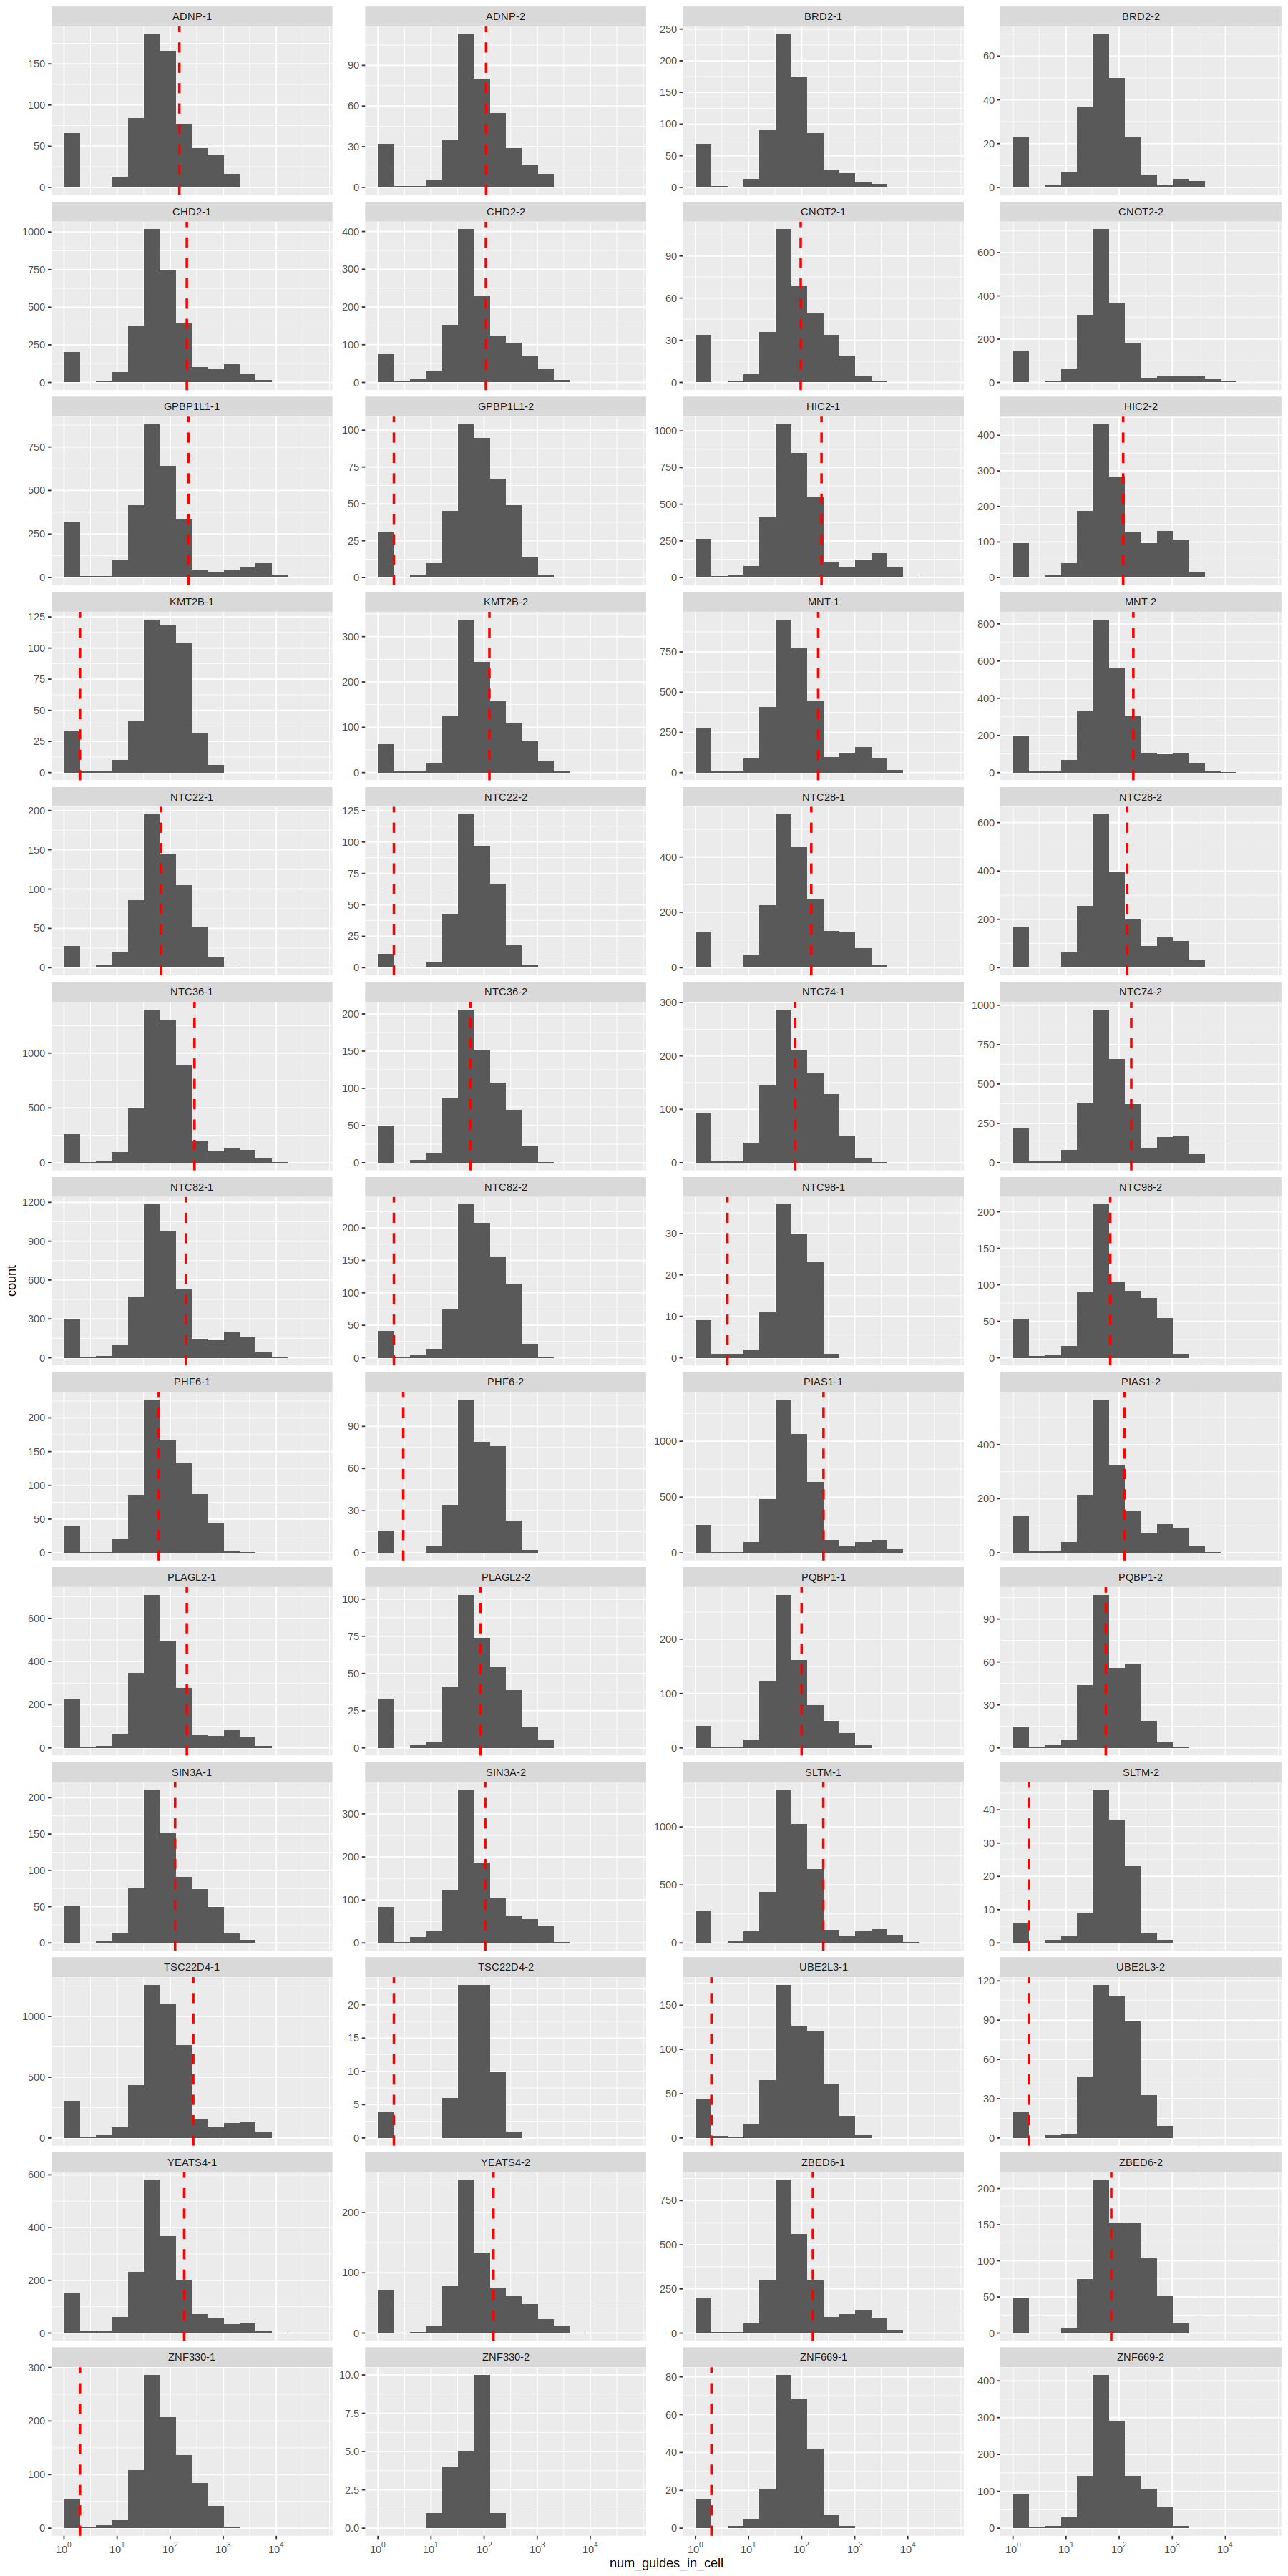

In [39]:
library(reshape2)
library(scales)
df_guide_counts_by_cell <- as.data.frame(t(as.data.frame(seurat$guidecapture@counts)))

d <- melt(df_guide_counts_by_cell)
d <- d[d$value > 0,]
colnames(d) = c("guide_name", "num_guides_in_cell")

bin_breaks <- c(1,2,2*2^(1:15))
options(repr.plot.width = 15, repr.plot.height = 30)
ggplot(d, aes(x = num_guides_in_cell)) + 
    geom_histogram(breaks = bin_breaks) +
    labs(y_label="count") +
    scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000)) +
    facet_wrap(~guide_name, scales = "free_y", ncol =  4)  + 
    geom_vline(data = df_thresholds_dummy, aes(xintercept = threshold), color="red", linetype="dashed", linewidth=1)



In [40]:
df_thresholds_dummy

threshold guide_name
1  149       ADNP-1    
2  109       ADNP-2    
3   NA       BRD2-1    
4   NA       BRD2-2    
5  206       CHD2-1    
6  108       CHD2-2    
7   96       CNOT2-1   
8   NA       CNOT2-2   
9  220       GPBP1L1-1 
10   2       GPBP1L1-2 
11 237       HIC2-1    
12 119       HIC2-2    
13   2       KMT2B-1   
14 126       KMT2B-2   
15 205       MNT-1     
16 185       MNT-2     
17  67       NTC22-1   
18   2       NTC22-2   
19 152       NTC28-1   
20 140       NTC28-2   
21 287       NTC36-1   
22  55       NTC36-2   
23  75       NTC74-1   
24 169       NTC74-2   
25 200       NTC82-1   
26   2       NTC82-2   
27   4       NTC98-1   
28  68       NTC98-2   
29  61       PHF6-1    
30   3       PHF6-2    
31 258       PIAS1-1   
32 126       PIAS1-2   
33 206       PLAGL2-1  
34  85       PLAGL2-2  
35 100       PQBP1-1   
36  56       PQBP1-2   
37 124       SIN3A-1   
38 105       SIN3A-2   
39 256       SLTM-1    
40   2       SLTM-2    
41 272       TSC22D4-1 
42   2       TSC22D4-2 
43   2       UBE2L3-1  
44   2       UBE2L3-2  
45 184       YEATS4-1  
46 150       YEATS4-2  
47 163       ZBED6-1   
48  71       ZBED6-2   
49   2       ZNF330-1  
50  NA       ZNF330-2  
51   2       ZNF669-1  
52  NA       ZNF669-2

# Singlet/doublet assignment

In [41]:
select_zeros = rowSums(df_calls) == 0
select_ones  = rowSums(df_calls) == 1
select_twos  = rowSums(df_calls) == 2
classes = rep('doublet', nrow(df_calls))
names(classes) = rownames(df_calls)
classes[select_zeros] = "no_call"
classes[select_ones]  = "singlet"

In [42]:
colnames(df_protosp) <- c("Gene", "GuideName", "PS")

If two guides are the same vector, assign 'singlet' status to cell

In [43]:
dual_call_cells = rownames(df_calls[select_twos, ])
guide_names = colnames(df_calls)

for(cell in dual_call_cells) {
    select_called = df_calls[cell, ]
    calls = as.vector(t(df_calls[cell, guide_names]))
    g1 = gsub("-", "_", guide_names[calls][1])
    g2 = gsub("-", "_", guide_names[calls][2])

    target1 = df_protosp[df_protosp$GuideName == g1,]$Gene    
    target2 = df_protosp[df_protosp$GuideName == g2,]$Gene    
    #print(paste(cell, target1, target2))

    if(target1 == target2) {        
        #print(paste(cell, target1, target2))
        classes[cell] = "singlet"
    }
}


### Normalize guide capture data

In [44]:
seurat

An object of class Seurat 
240768 features across 8507 samples within 4 assays 
Active assay: SCT (22035 features, 3000 variable features)
 3 other assays present: ATAC, RNA, guidecapture
 5 dimensional reductions calculated: lsi, umap.atac, wnn.umap, pca, umap.rna

In [45]:
DefaultAssay(seurat) <- "guidecapture"

# find cells with 0 counts and drop them
# Assuming your Seurat object is named 'seurat_obj'
count_matrix <- seurat[["guidecapture"]]@counts  # Replace "RNA" with the name of your current assay if different

# Find cells with 0 counts
zero_count_cells <- colnames(count_matrix)[colSums(count_matrix) == 0]

# Drop those cells from the Seurat object
seurat <- subset(seurat, cells = setdiff(colnames(seurat), zero_count_cells))

In [46]:
seurat

An object of class Seurat 
240768 features across 8507 samples within 4 assays 
Active assay: guidecapture (52 features, 0 variable features)
 3 other assays present: SCT, ATAC, RNA
 5 dimensional reductions calculated: lsi, umap.atac, wnn.umap, pca, umap.rna

In [47]:
DefaultAssay(seurat) <- "guidecapture"
npcs = 30

seurat <- SCTransform(seurat, assay = 'guidecapture', method = "glmGamPoi", vst.flavor = "v2", verbose = FALSE, new.assay.name = "crisprSCT")  %>% 
          RunPCA(verbose=FALSE, assay = 'crisprSCT', reduction.name = 'crisprPCA', npcs=npcs) %>% 
          RunUMAP(dims = 1:npcs, reduction.name = 'umap.guide', reduction.key = 'guideUMAP_', verbose=FALSE)

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames =

Update singlet/doublet status in seurat object

In [48]:
#seurat@meta.data[, guide_names] = NULL
#seurat@meta.data = merge(seurat@meta.data, df_calls, by = 0)

# Visualization

In [49]:
guide_names = sort(rownames(seurat[['crisprSCT']]@scale.data))
options(repr.plot.width = 20, repr.plot.height = 10)
#DoHeatmap(seurat, assay = 'crisprSCT', features = guide_names) + NoLegend()


In [50]:
nrow(seurat@meta.data)
nrow(df_calls)

[1] 8507

[1] 8507

In [51]:
df_calls_and_classes = df_calls
df_calls_and_classes$class = classes

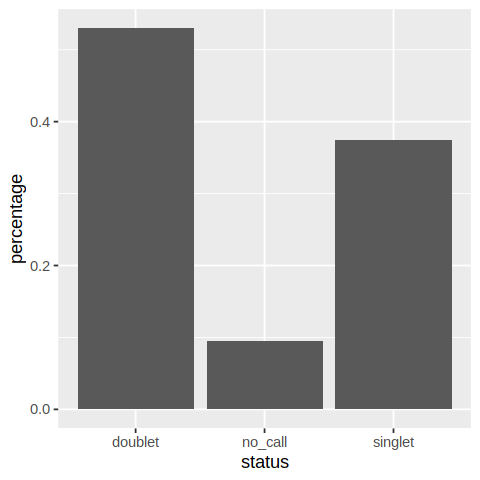

In [52]:
df_dummy = as.data.frame(table(df_calls_and_classes$class))
colnames(df_dummy) <- c("status", "count")
df_dummy$percentage = df_dummy$count/(sum(df_dummy$count))
options(repr.plot.width = 4, repr.plot.height = 4)
ggplot(df_dummy, aes(x = status, y = percentage)) +
    geom_bar(stat = "identity")

## Select the singlets, create a column with the assigned guides, also assign target name

In [53]:
select_singlets = df_calls_and_classes$class == 'singlet'
df_singlets = df_calls_and_classes[select_singlets,]

In [54]:
n_singlets = nrow(df_singlets)
n_doublets = nrow(df_calls_and_classes) - n_singlets
perc_singlet = n_singlets / (n_singlets + n_doublets)
cat(blue("#singlets", n_singlets, "\n"))
cat(blue("#doublets", n_doublets, "\n"))
cat(blue("%singlets", perc_singlet, "\n"))

#singlets 3189 
#doublets 5318 
%singlets 0.374867755965675 


In [55]:
# Singlets w/ one guide detected vs two guides
table(rowSums(df_singlets[,guide_names]))


   1    2 
1853 1336 

In [56]:
nrow(seurat@meta.data)

[1] 8507

### Find the target gene

In [57]:
singlet_cells = rownames(df_singlets)
guide_names = colnames(df_calls)
targets = vector()
detected = vector()
for(cell in singlet_cells) {
    target = ""
    detected_guides = 0
    select_called = df_singlets[cell, ]
    calls = as.vector(t(df_singlets[cell, guide_names]))
    g1 = guide_names[calls][1]
    g2 = guide_names[calls][2]

    if(!is.na(g1)) {
        g1 = gsub("-", "_", g1)
        target = df_protosp[df_protosp$GuideName == g1,]$Gene        
    } else if(!is.na(g2)) {
        g2 = gsub("-", "_", g2)
        target = df_protosp[df_protosp$GuideName == g2,]$Gene
    }
    targets = c(targets, target)
    detected = c(detected, sum(!is.na(c(g1, g2))))
    #print(target)
}
df_singlets$vector      = targets
df_singlets$target_gene = str_split_fixed(targets, "_", 2)[,1]
df_singlets$detected_guides_from_vector = detected

In [58]:
sample_n(df_singlets,3)

ADNP-1 ADNP-2 BRD2-1 BRD2-2 CHD2-1 CHD2-2 CNOT2-1 CNOT2-2
GCTGTGCAGCCTGAGC-1 FALSE  FALSE  FALSE  FALSE  FALSE  FALSE  FALSE   FALSE  
TGTCAGTAGTCACTAA-1 FALSE  FALSE  FALSE  FALSE  FALSE  FALSE  FALSE   FALSE  
GGATAACCATAAACCT-1 FALSE  FALSE  FALSE  FALSE  FALSE  FALSE  FALSE   FALSE  
                   GPBP1L1-1 GPBP1L1-2 ⋯ ZBED6-1 ZBED6-2 ZNF330-1 ZNF330-2
GCTGTGCAGCCTGAGC-1 FALSE     FALSE     ⋯ FALSE   FALSE   FALSE    FALSE   
TGTCAGTAGTCACTAA-1 FALSE     FALSE     ⋯ FALSE   FALSE   FALSE    FALSE   
GGATAACCATAAACCT-1 FALSE     FALSE     ⋯ FALSE   FALSE   FALSE    FALSE   
                   ZNF669-1 ZNF669-2 class   vector target_gene
GCTGTGCAGCCTGAGC-1 FALSE    FALSE    singlet SIN3A  SIN3A      
TGTCAGTAGTCACTAA-1 FALSE    FALSE    singlet NTC82  NTC82      
GGATAACCATAAACCT-1 FALSE    FALSE    singlet PIAS1  PIAS1      
                   detected_guides_from_vector
GCTGTGCAGCCTGAGC-1 2                          
TGTCAGTAGTCACTAA-1 2                          
GGATAACCATAAACCT-1 2

### Subset seurat object

In [59]:
seurat_singlets = subset(seurat, cells = singlet_cells)

In [60]:
Idents(seurat_singlets) = df_singlets$vector

In [61]:
npcs = 30
DefaultAssay(seurat) <- "RNA"
seurat_singlets <- SCTransform(seurat_singlets, method = "glmGamPoi", vst.flavor = "v2", verbose = FALSE, new.assay.name = "SCT", return.only.var.genes = FALSE)  %>% 
          RunPCA(verbose=FALSE) %>% 
          RunUMAP(dims = 1:npcs, reduction.name = 'umap.rna', reduction.key = 'rnaUMAP_', verbose=FALSE)

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames =

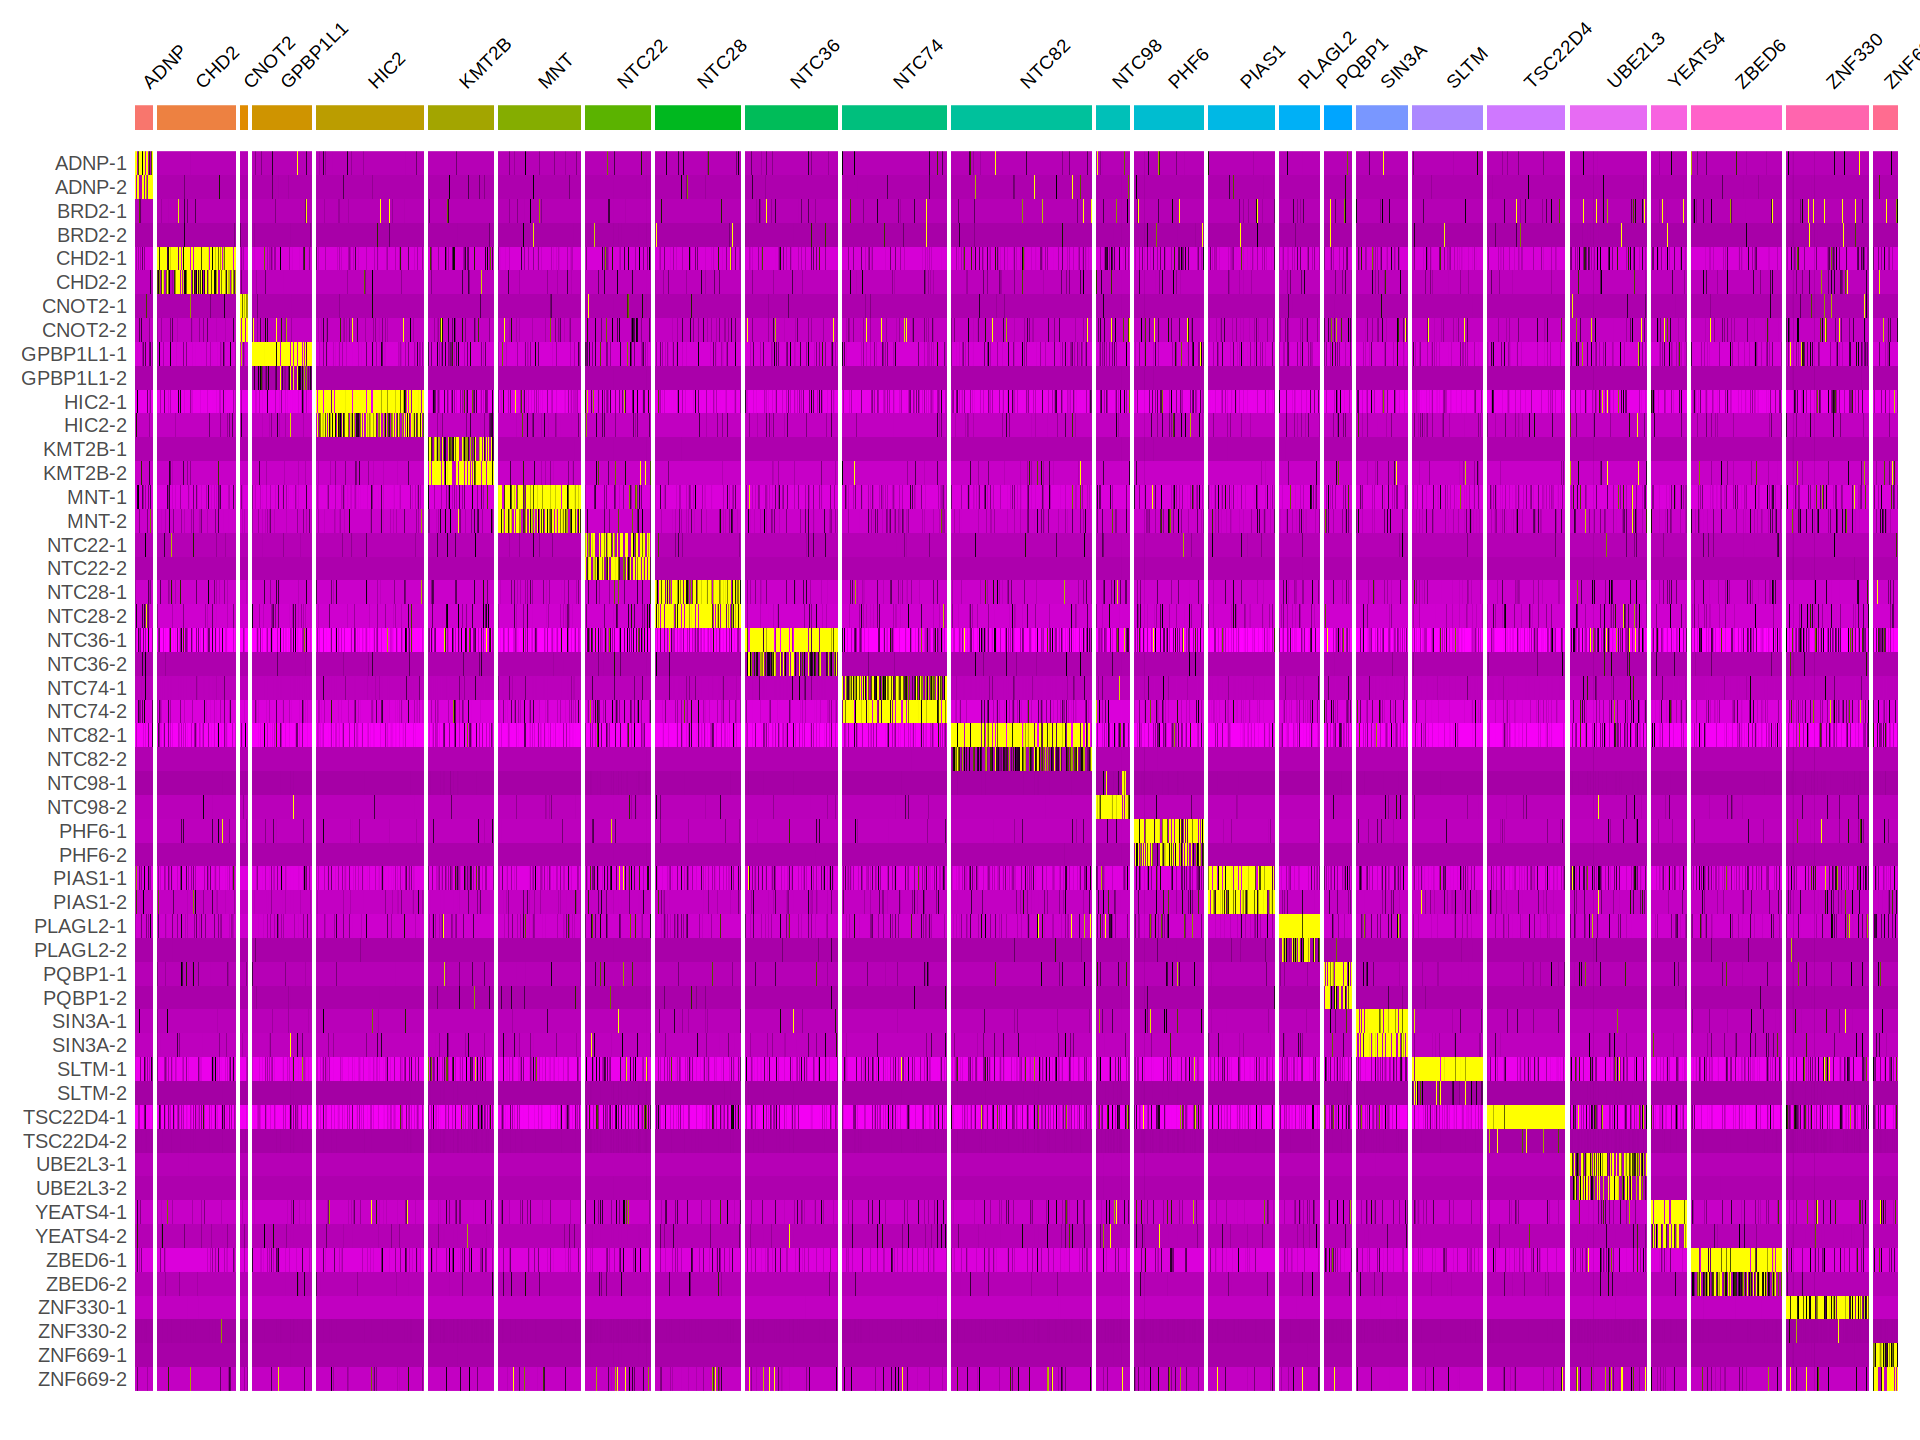

In [62]:
options(repr.plot.width = 16, repr.plot.height = 12)
guide_names = sort(unique(rownames(seurat_singlets[['crisprSCT']]@scale.data)))
levels(seurat_singlets) = sort(levels(seurat_singlets))
DoHeatmap(seurat_singlets, assay = "crisprSCT", features = guide_names, size = 4) + 
    theme(axis.text.y = element_text(size = 12)) + 
    NoLegend()

Warning message in DoHeatmap(seurat_singlets, assay = "SCT", features = sort(gene_names), :
“The following features were omitted as they were not found in the scale.data slot for the SCT assay: NTC98, NTC82, NTC74, NTC36, NTC28, NTC22”


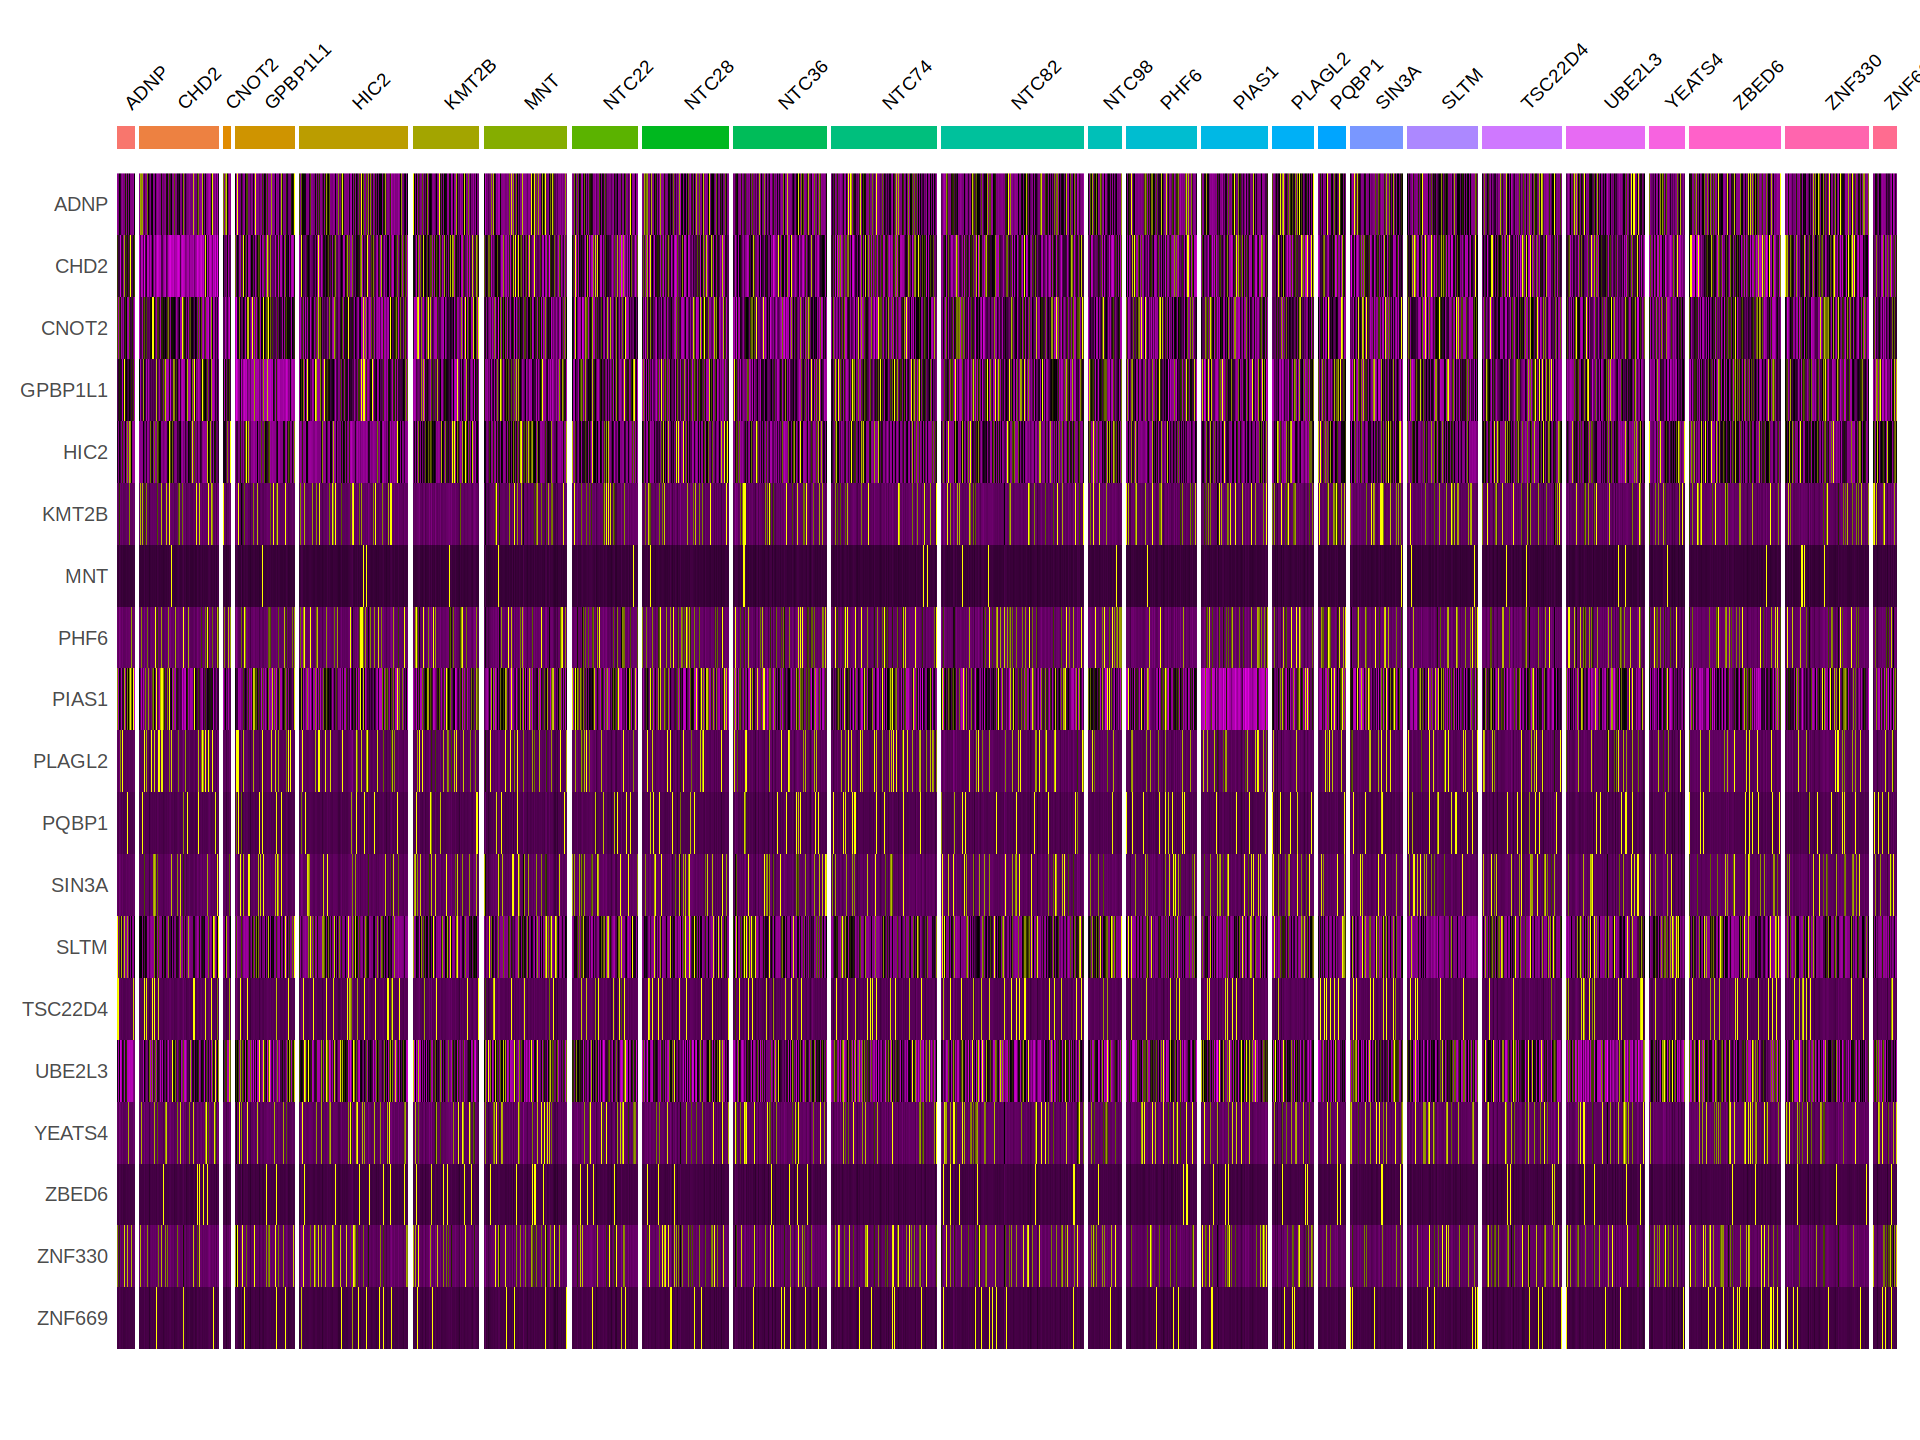

In [63]:
options(repr.plot.width = 16, repr.plot.height = 12)
gene_names = unique(df_singlets$target_gene)

DefaultAssay(seurat_singlets) = "SCT"
Idents(seurat_singlets) = df_singlets$vector
levels(seurat_singlets) = sort(levels(seurat_singlets))
DoHeatmap(seurat_singlets, assay = "SCT", features = sort(gene_names), size = 4) + 
    theme(axis.text.y = element_text(size = 12)) + 
    NoLegend()

### Violin plots


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




$`1`

$`2`

attr(,"class")
[1] "list"      "ggarrange"

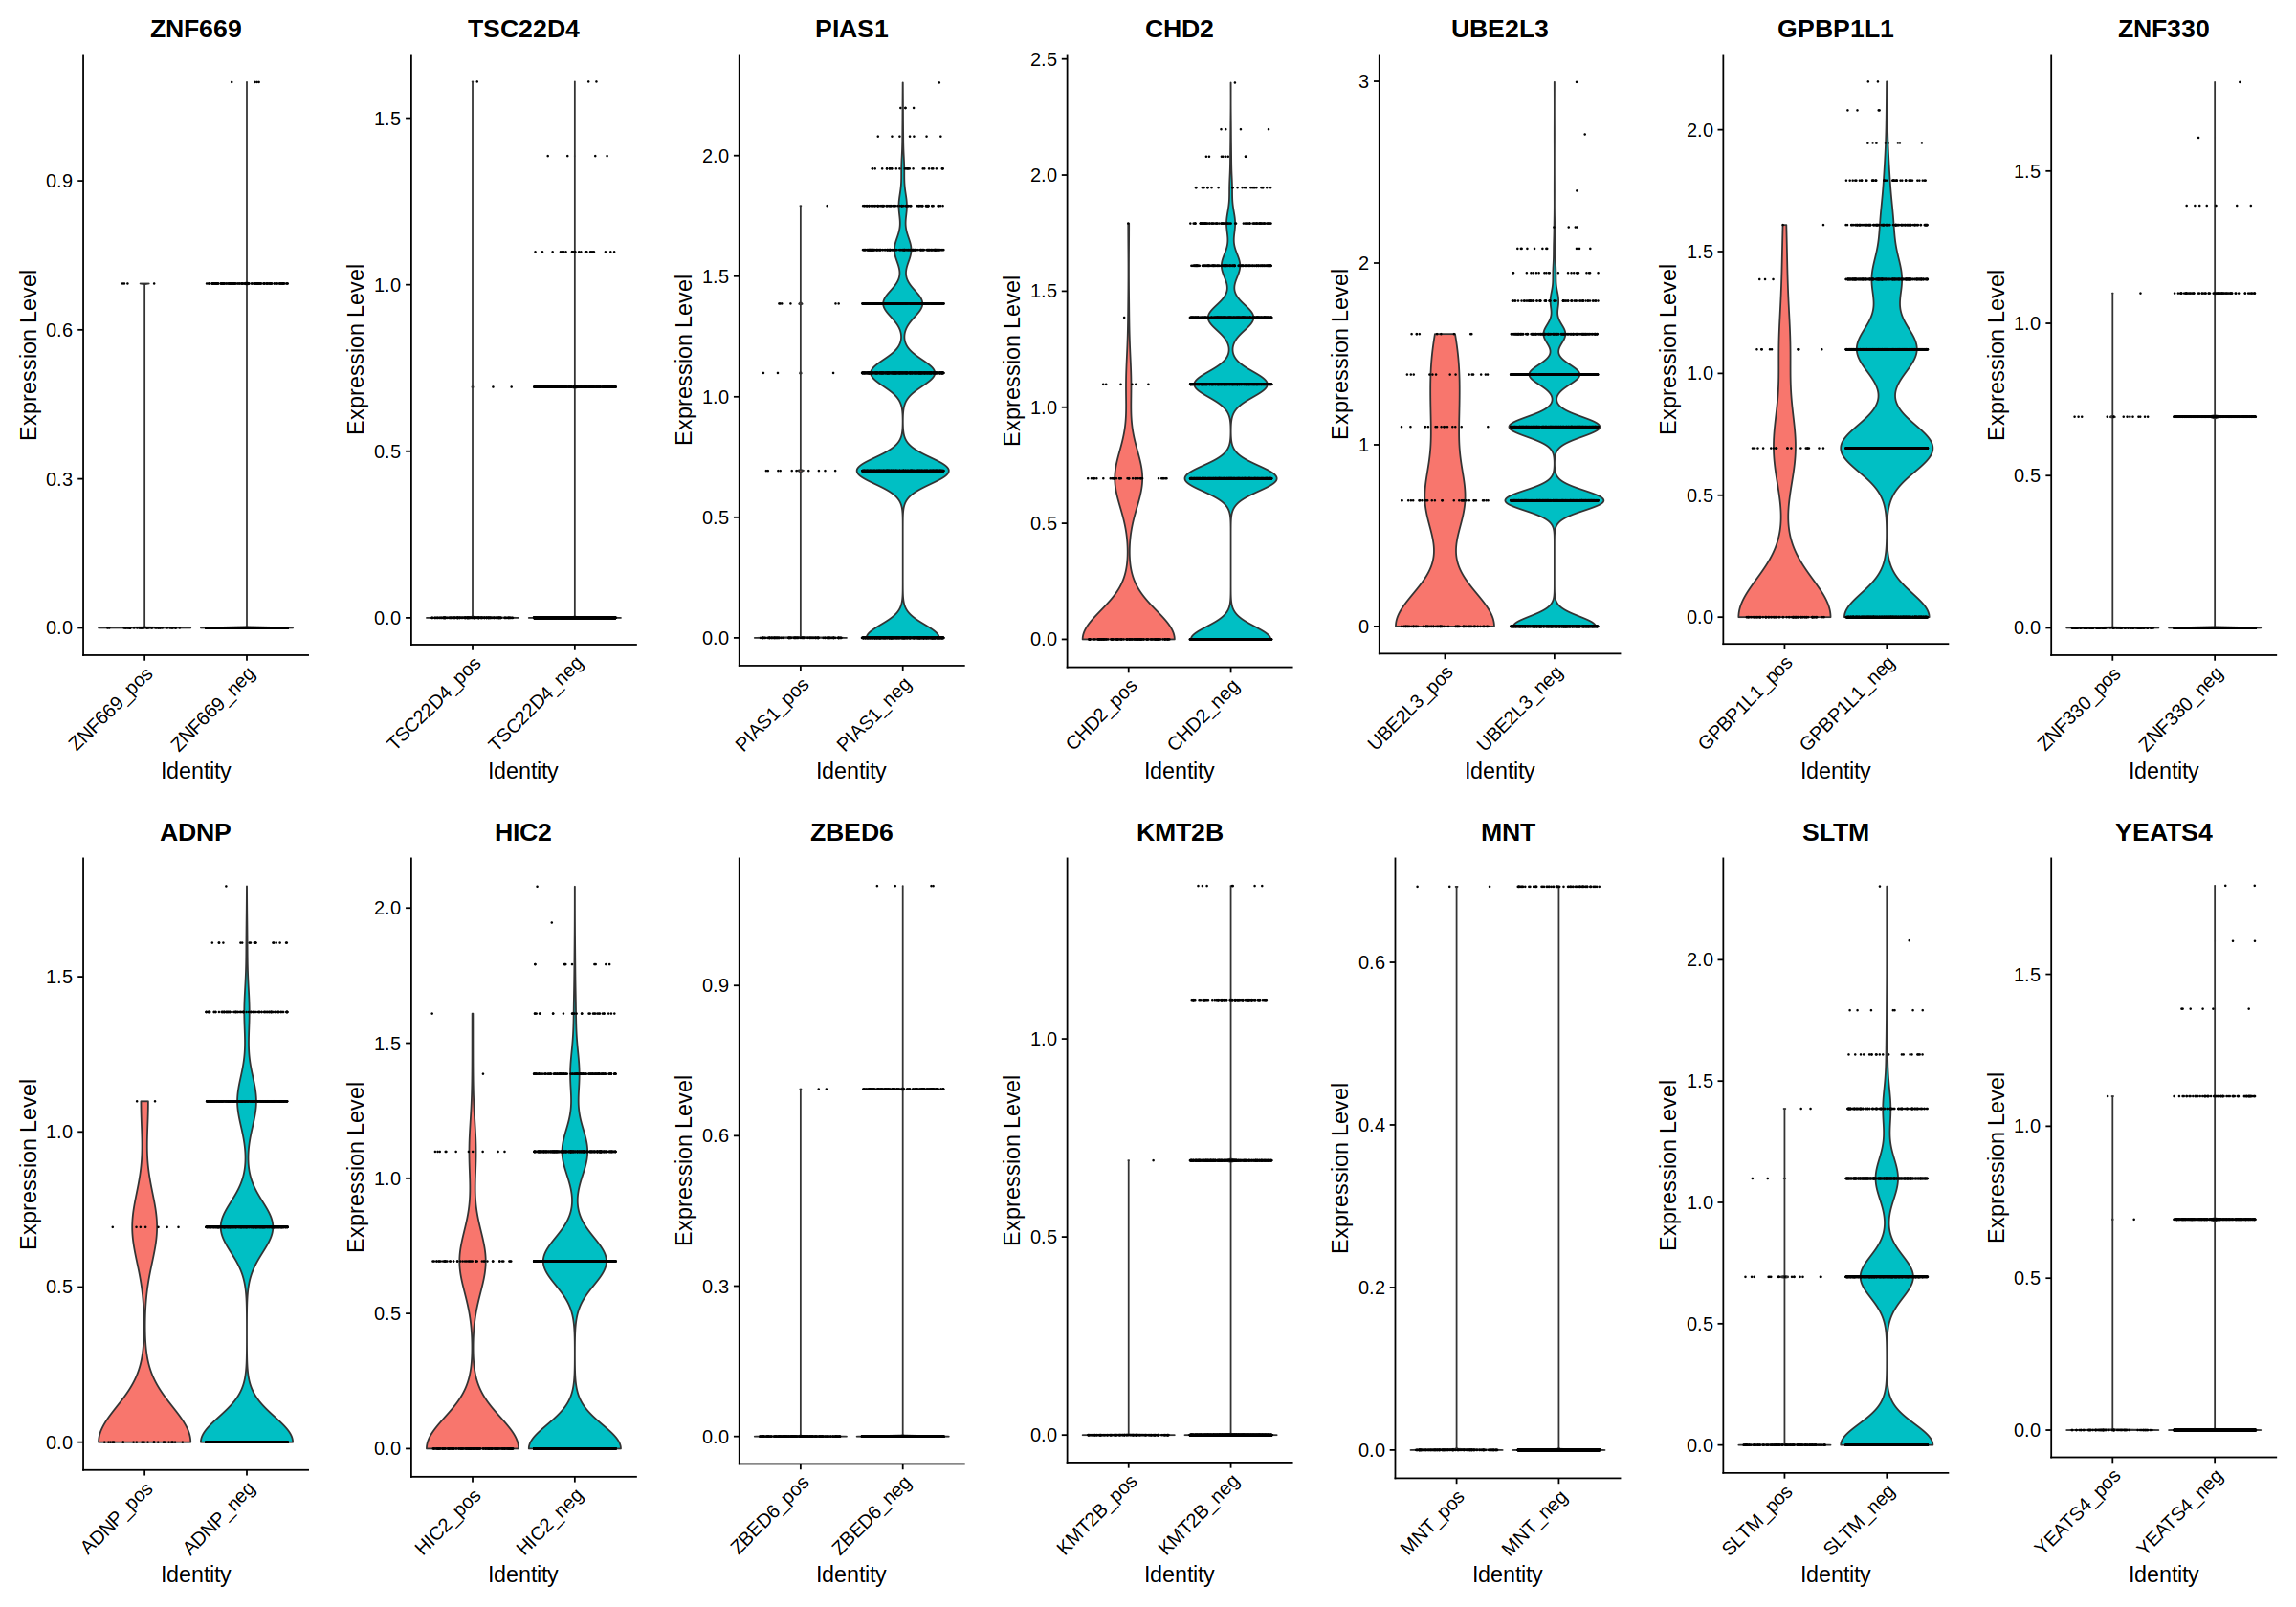

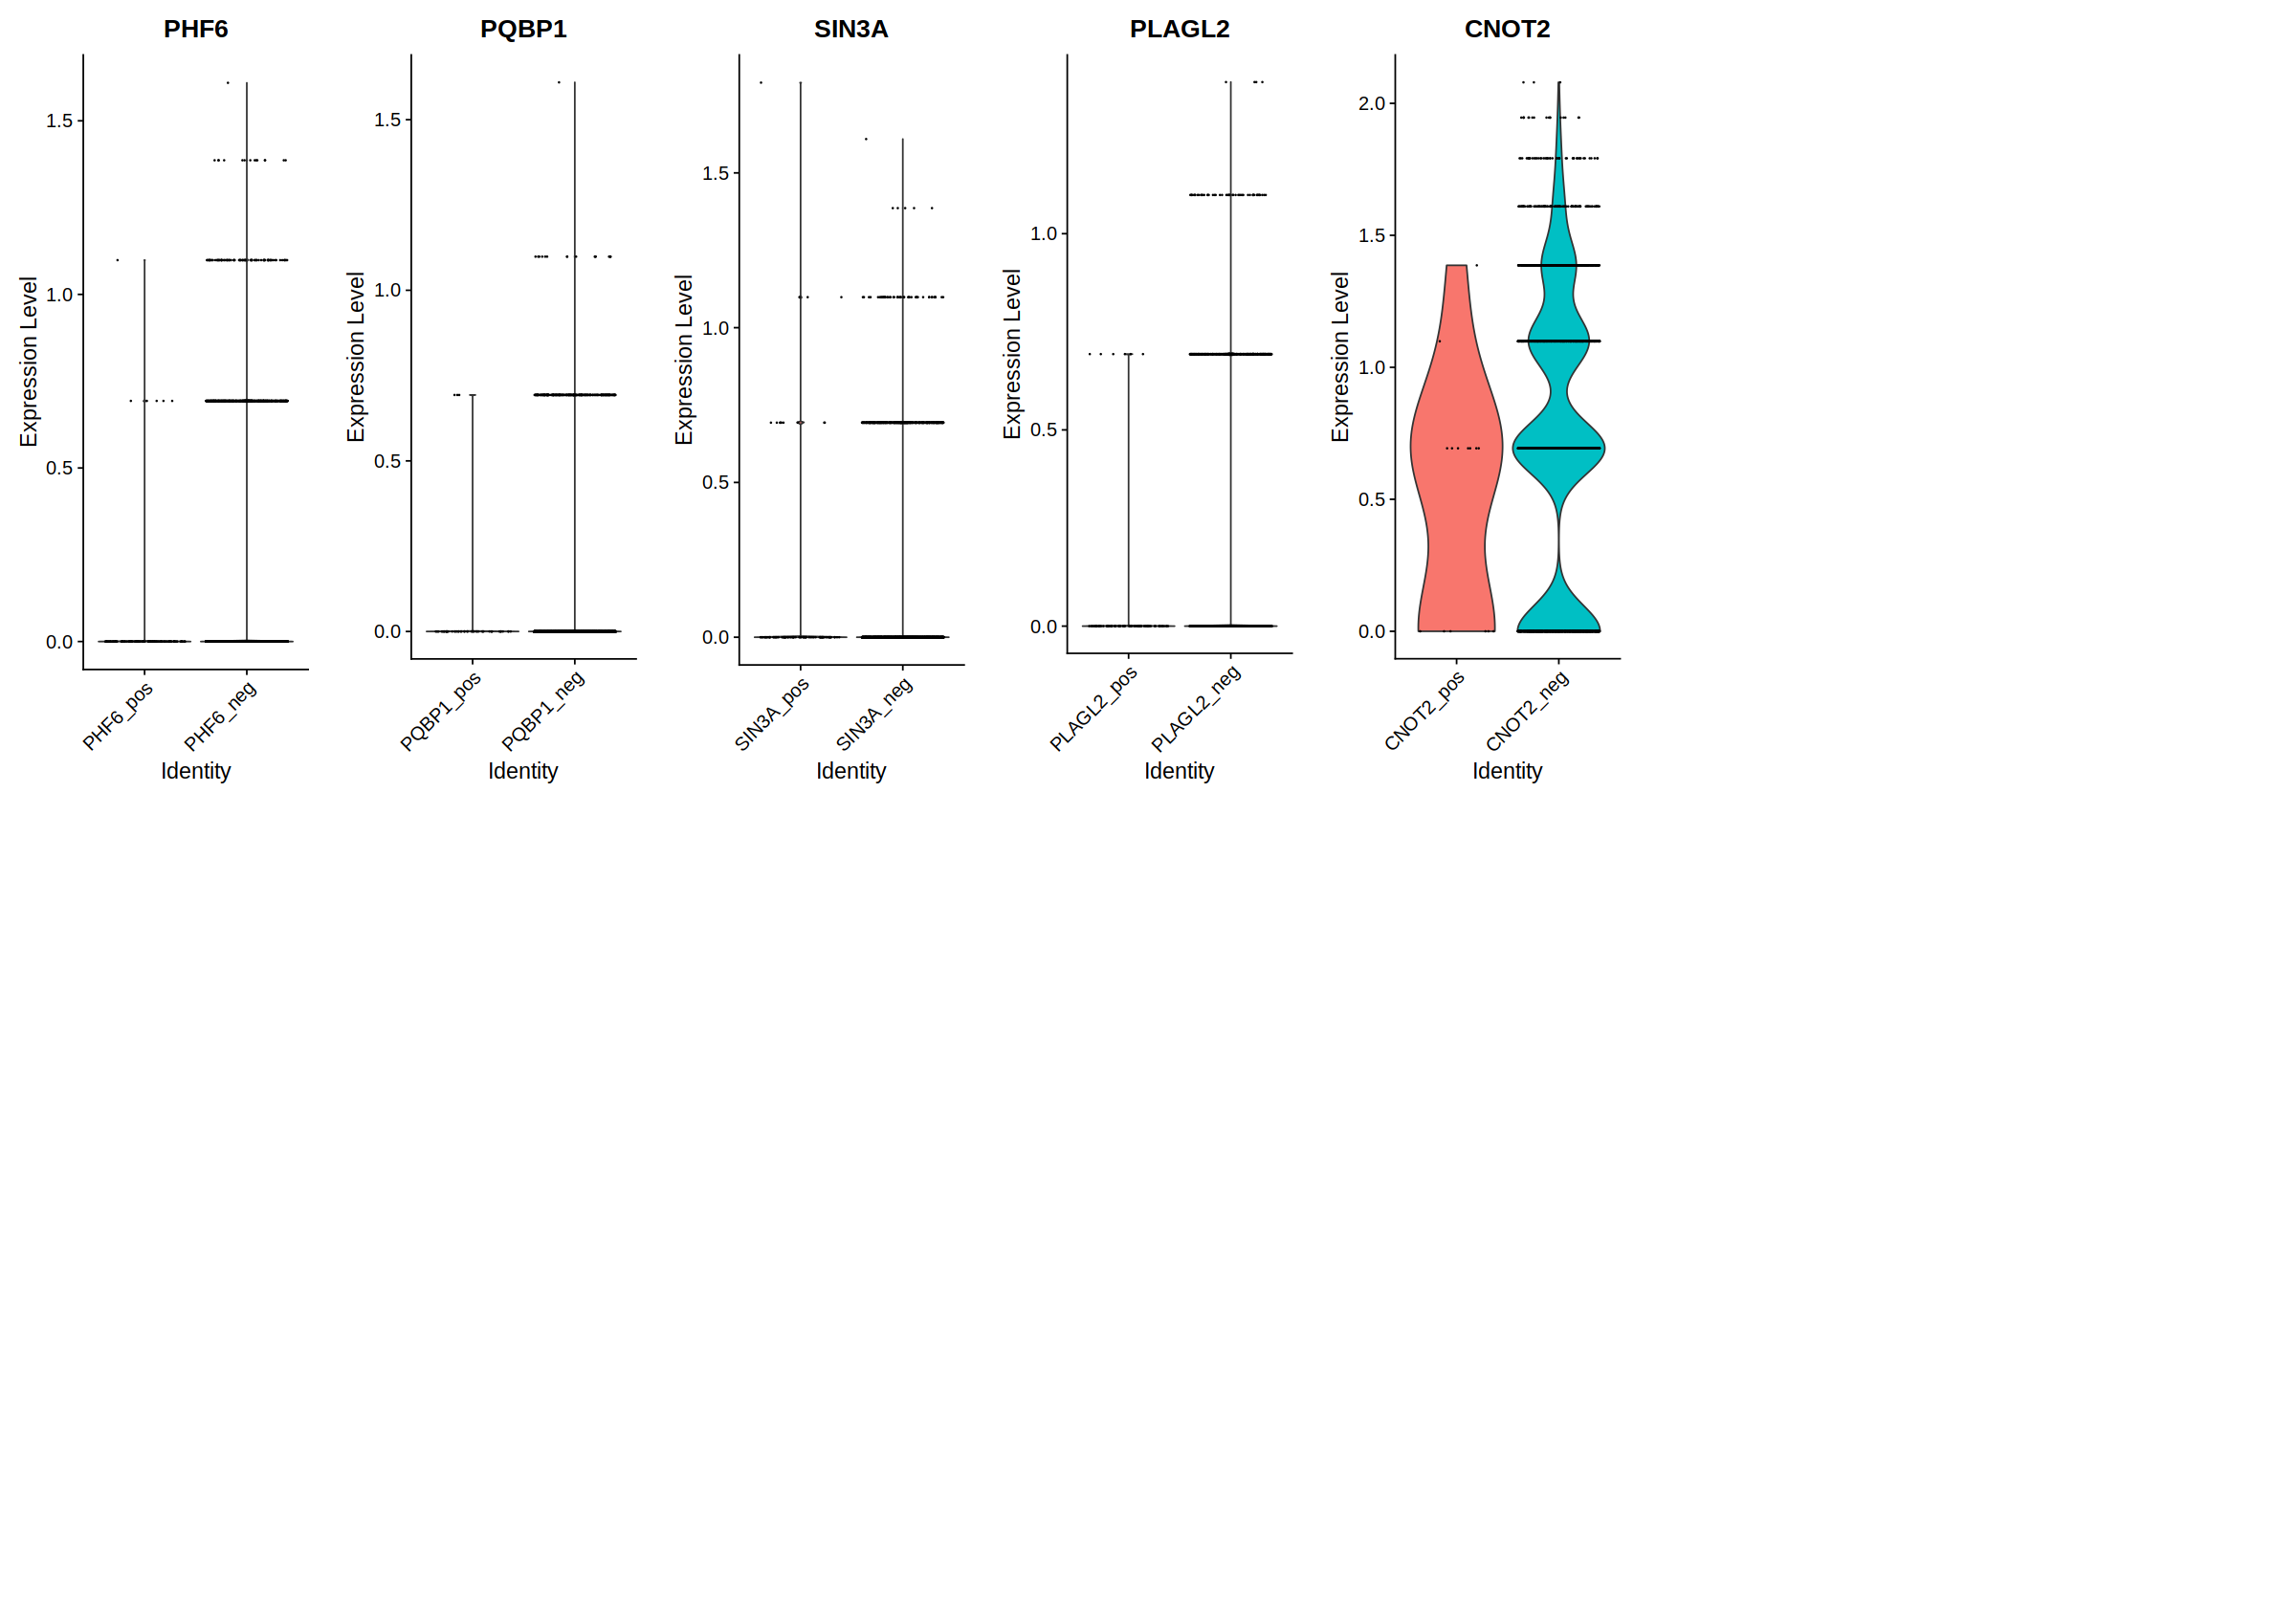

In [64]:
library(gridExtra)
library(patchwork)
library(ggpubr)
genes_in_assay = rownames(seurat_singlets[['SCT']]@scale.data)
plots = list()

for(i in 1:length(gene_names)){
    gene = gene_names[[i]]    
    if(("NTCTL" %in% gene) | !(gene %in% genes_in_assay)) {
        next
    }

    guides = paste0(gene, c('-1','-2', '-3','-4'))
    selected_cells = rownames(df_singlets[df_singlets$target_gene == gene, ])

    options(repr.plot.width = 4, repr.plot.height = 6)
    Idents(seurat_singlets) = paste0(gene, "_neg")
    Idents(seurat_singlets, cells = selected_cells) = paste0(gene, "_pos")
    plt = VlnPlot(seurat_singlets, assay="SCT", features = gene) + NoLegend()
    j = length(plots) + 1
    plots[[j]] = plt
}   

options(repr.plot.width=20, repr.plot.height=14)
ggarrange(plotlist=plots, ncol=7, nrow = 2)

# Plot clusters

ZNF669 
TSC22D4 


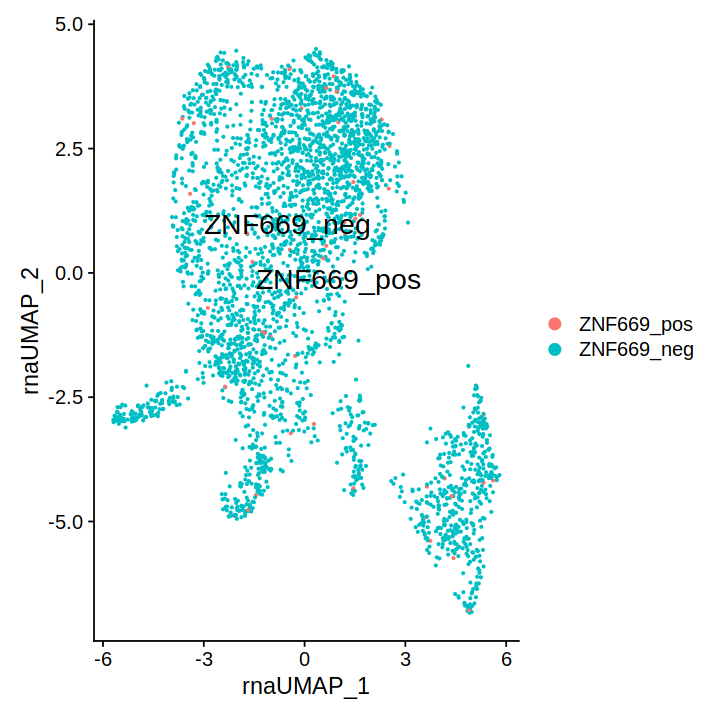

PIAS1 


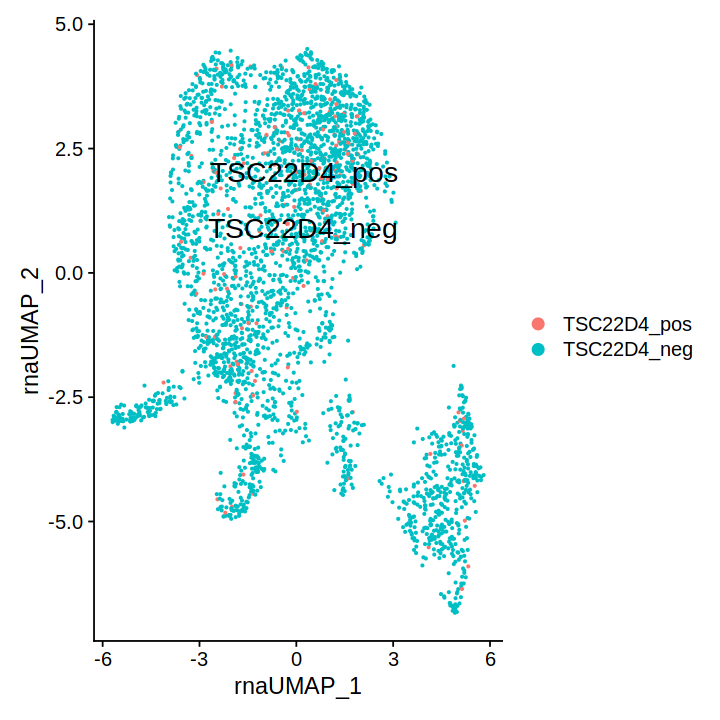

CHD2 


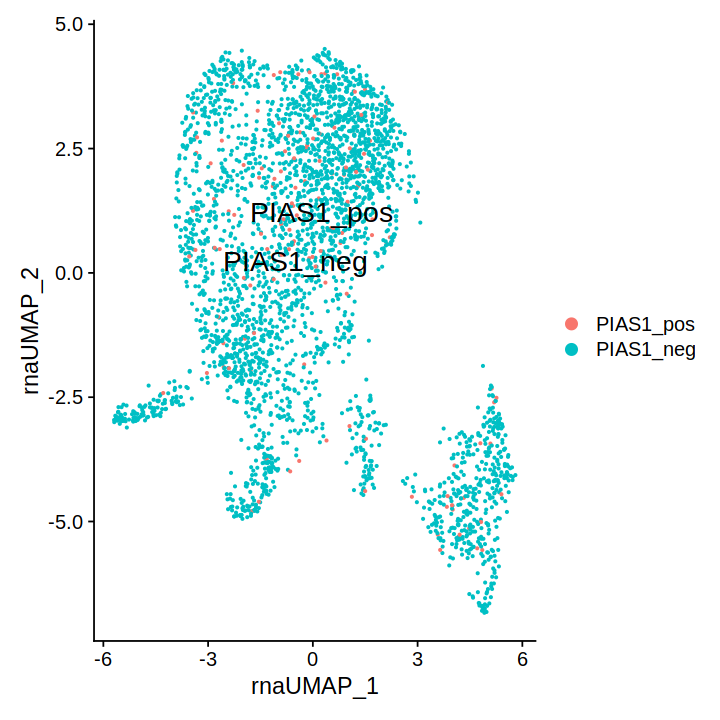

UBE2L3 


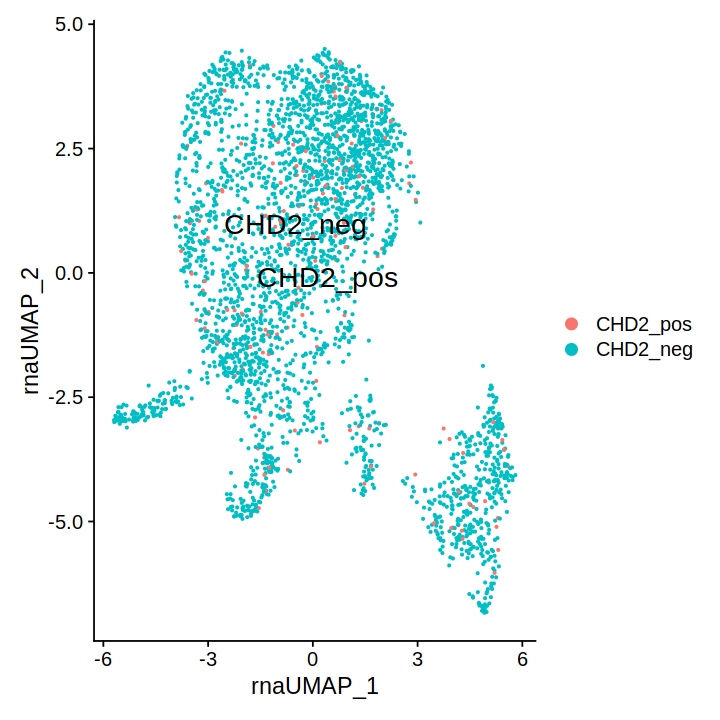

GPBP1L1 


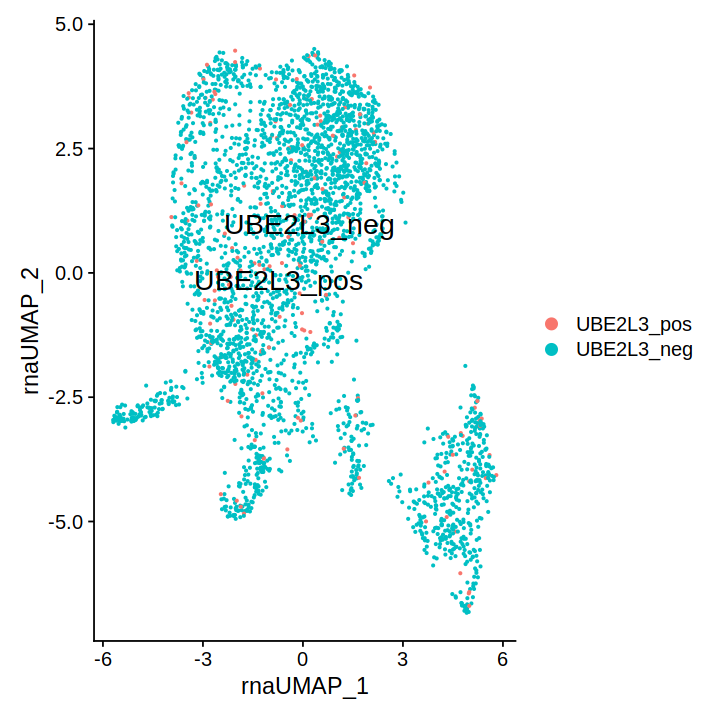

ZNF330 


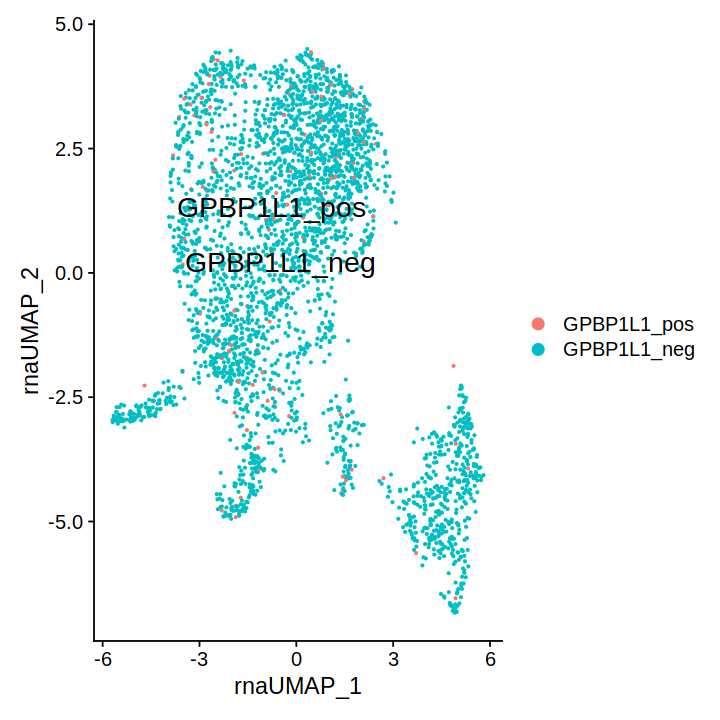

ADNP 


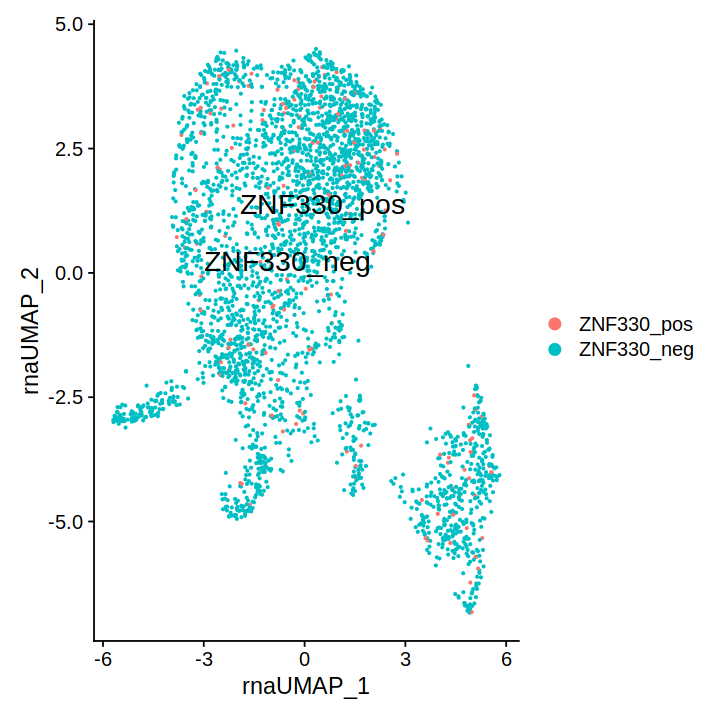

HIC2 


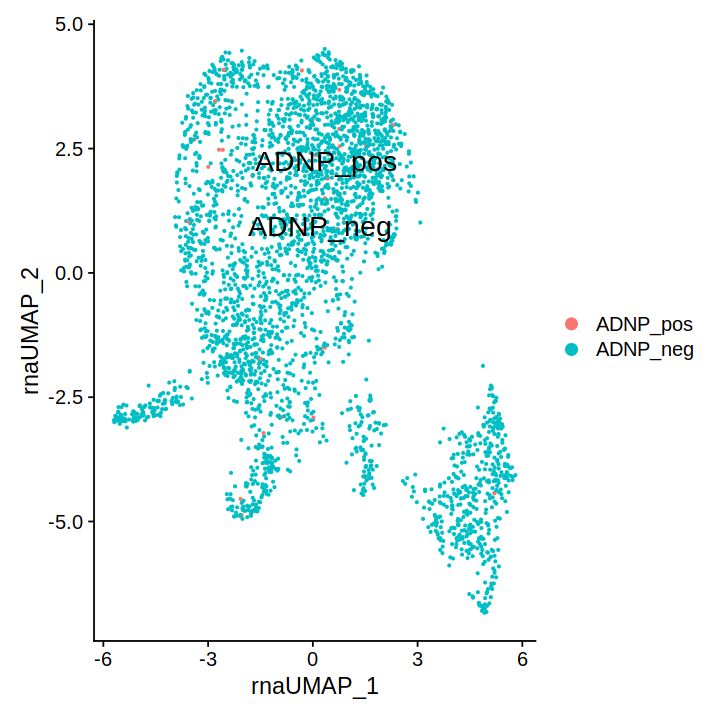

ZBED6 


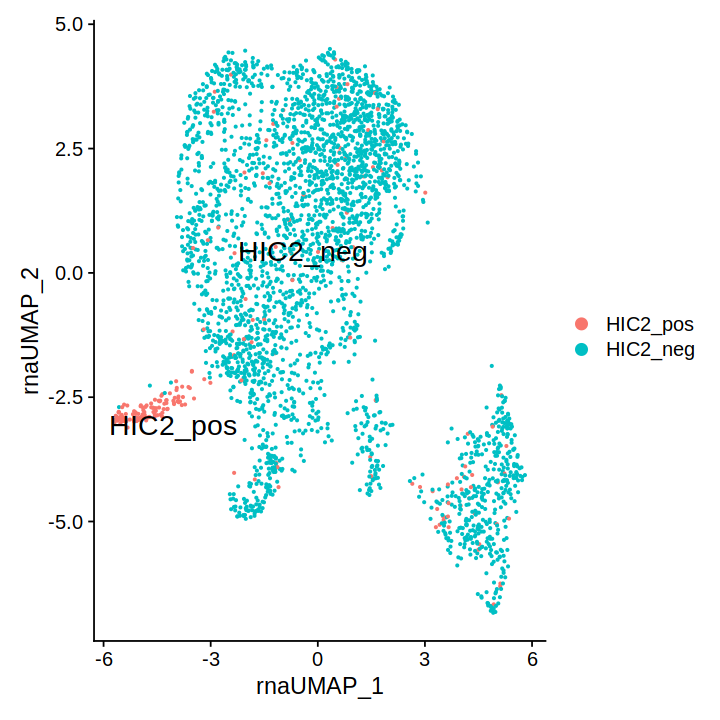

KMT2B 


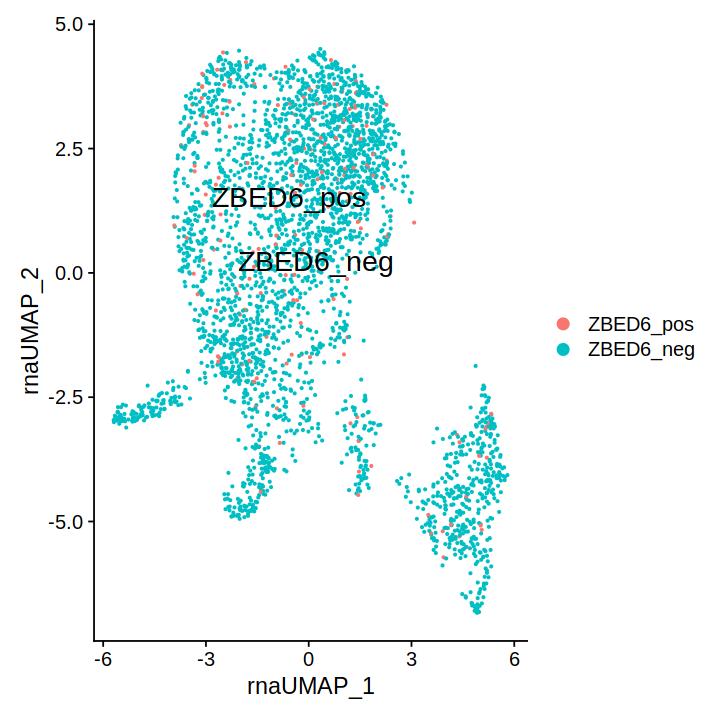

MNT 


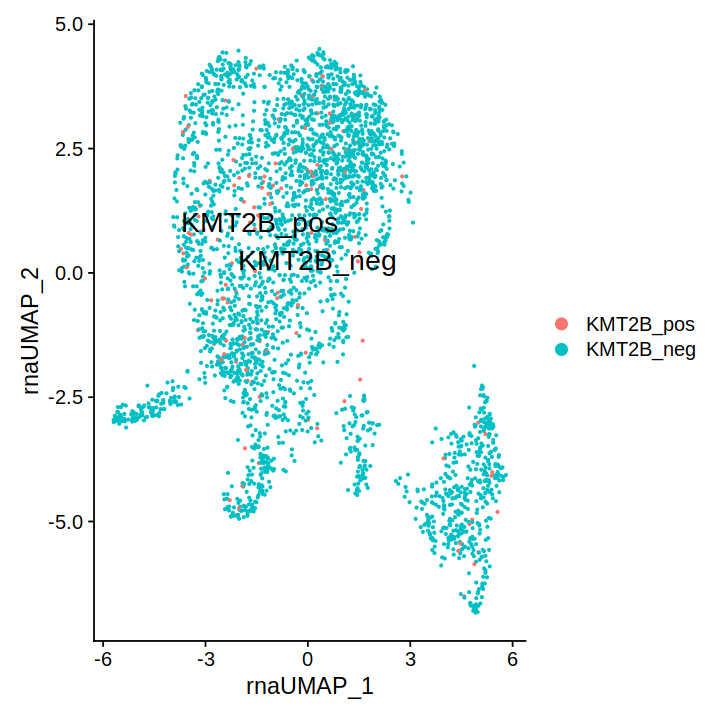

SLTM 


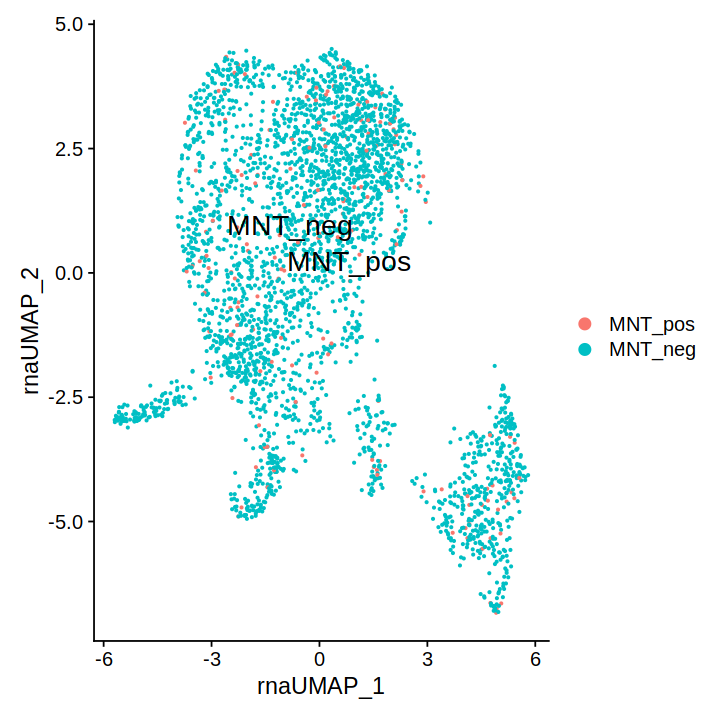

YEATS4 


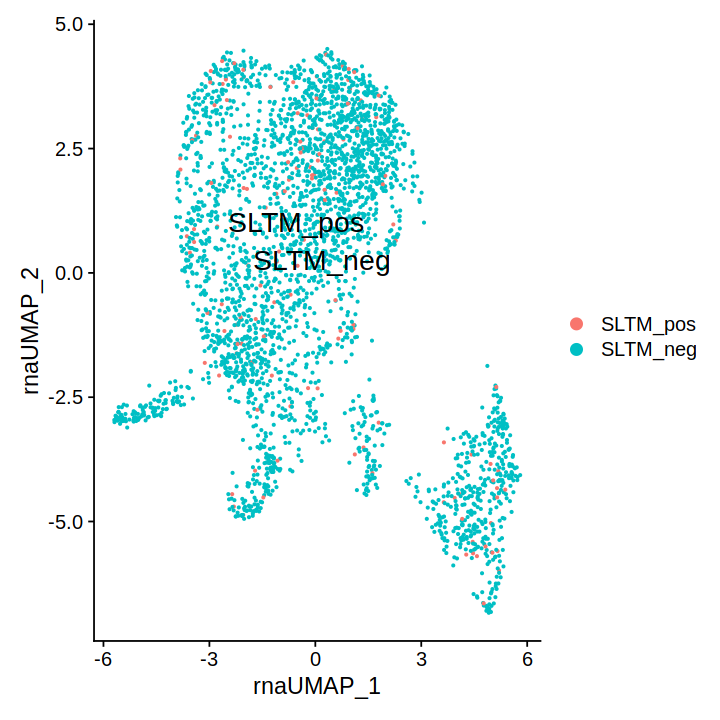

PHF6 


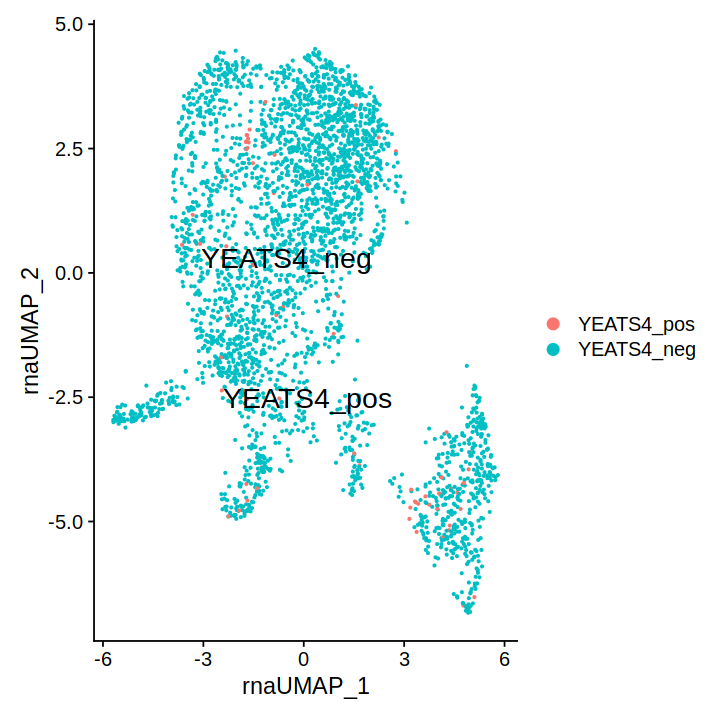

PQBP1 


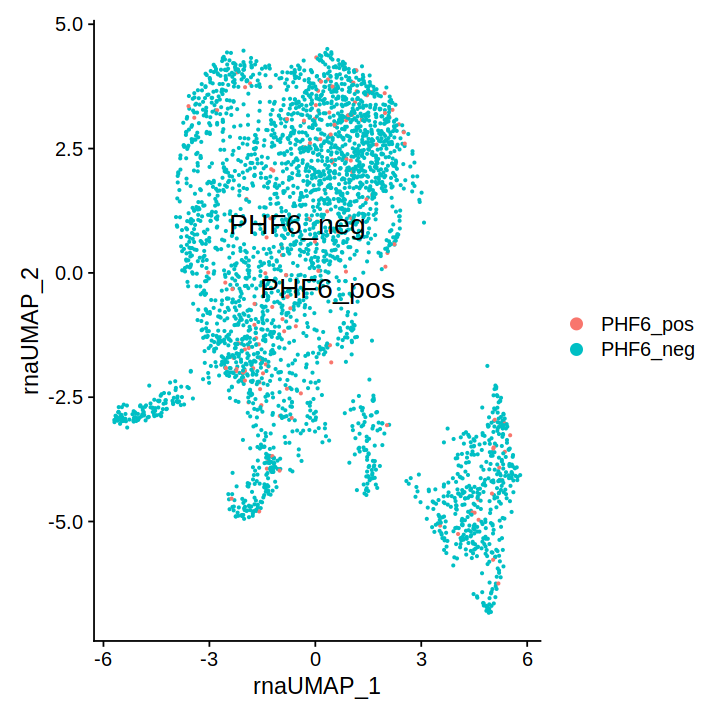

SIN3A 


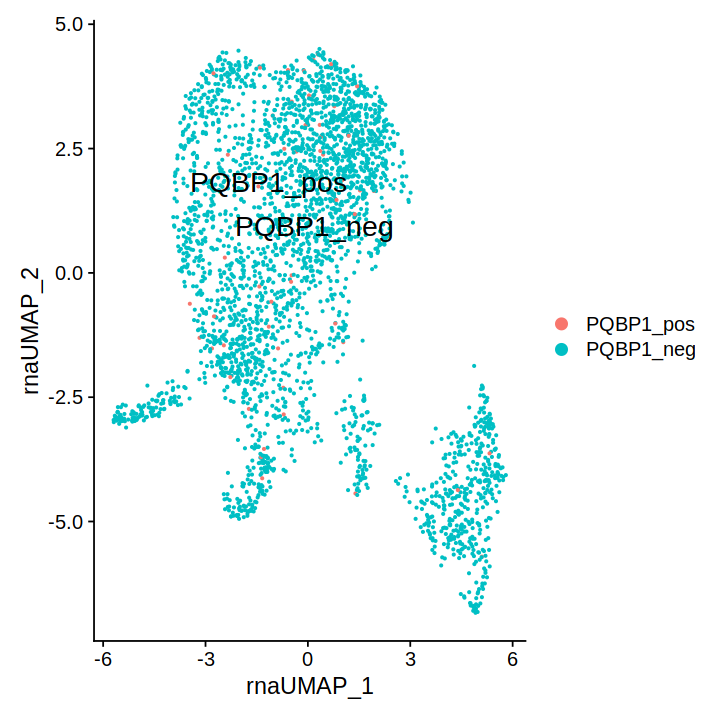

PLAGL2 


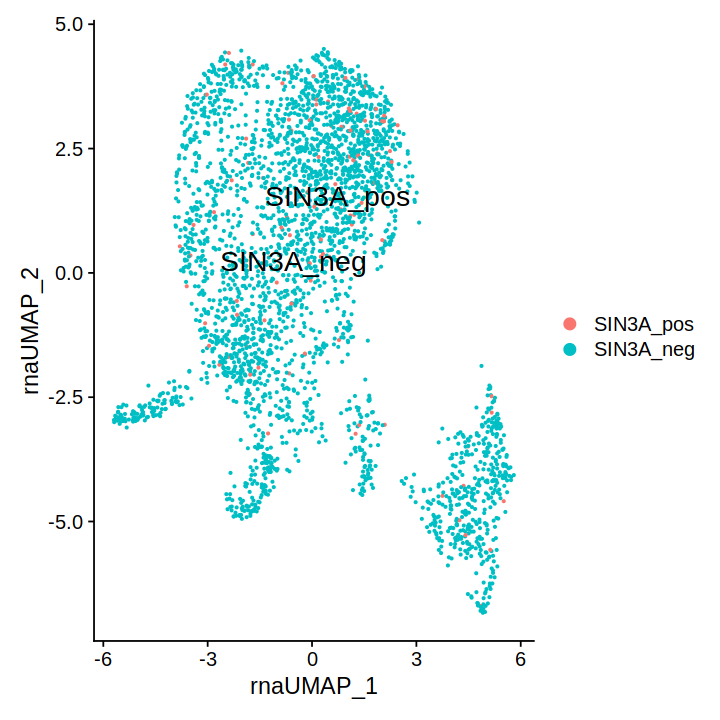

CNOT2 


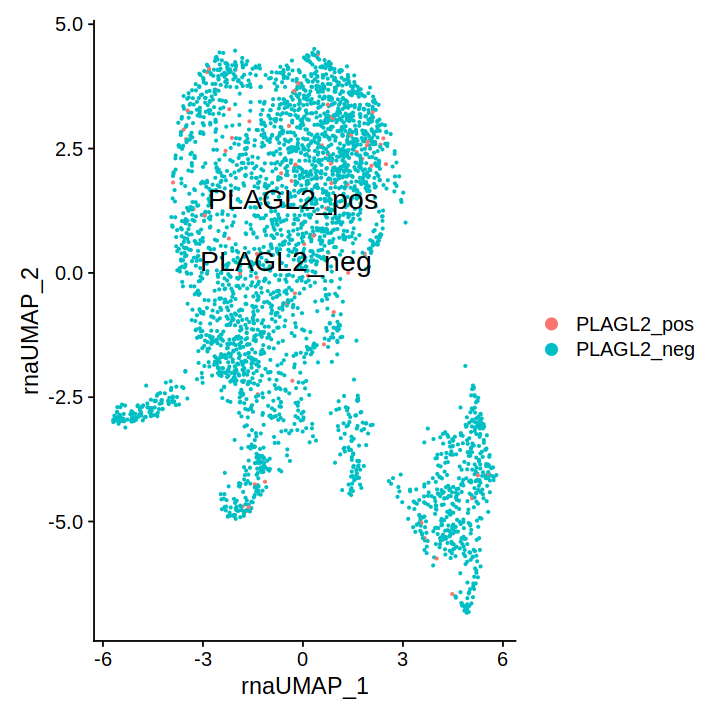

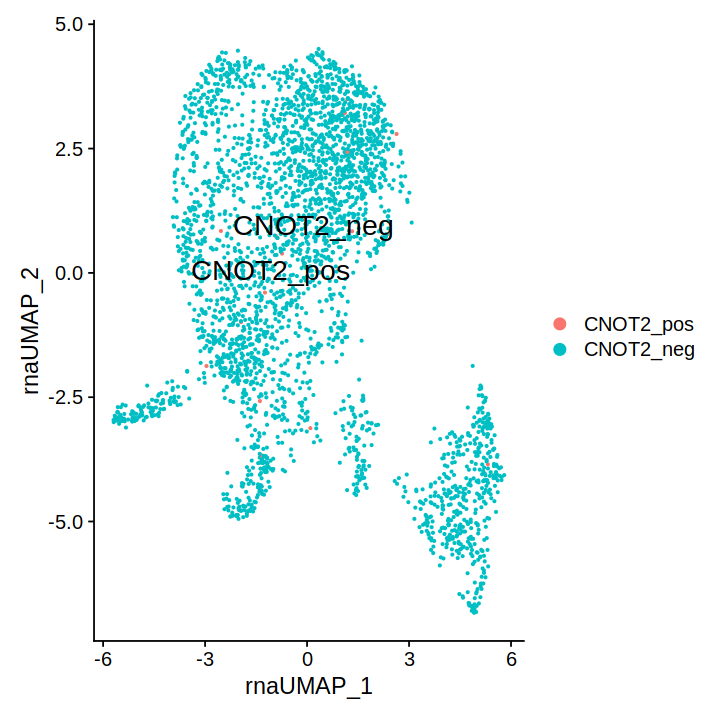

In [65]:
library(gridExtra)
library(patchwork)
library(ggpubr)
genes_in_assay = rownames(seurat_singlets[['SCT']]@scale.data)
plots = list()
options(repr.plot.width=5, repr.plot.height=5)

for(i in 1:length(gene_names)){
    gene = gene_names[[i]]    
    if(("NTCTL" %in% gene) | !(gene %in% genes_in_assay)) {
        next
    }
    cat(blue(gene), "\n")

    guides = paste0(gene, c('-1','-2', '-3','-4'))
    selected_cells = rownames(df_singlets[df_singlets$target_gene == gene, ])

    options(repr.plot.width = 6, repr.plot.height = 6)
    Idents(seurat_singlets) = paste0(gene, "_neg")
    Idents(seurat_singlets, cells = selected_cells) = paste0(gene, "_pos")
    plt = DimPlot(seurat_singlets, reduction = "umap.rna", label = TRUE, label.size = 6, repel = TRUE)
    j = length(plots) + 1
    plots[[j]] = plt
    print(plt)
}   


In [66]:
seurat

An object of class Seurat 
240820 features across 8507 samples within 5 assays 
Active assay: RNA (36601 features, 0 variable features)
 4 other assays present: SCT, ATAC, guidecapture, crisprSCT
 7 dimensional reductions calculated: lsi, umap.atac, wnn.umap, pca, umap.rna, crisprPCA, umap.guide

# Assign guides and save

In [ ]:
##################
# Assign a guide to each cell, appends new col to sobj@metadata called guidecapture_classification
# Inputs:
# sobj: sobj containing singlets from new guide caller notebook
# call_df: unfiltered df of calls from new guide caller notebook
# returns:
# sobj: sobj with new metadata col with guidecapture information
##################
assign_guides <- function(sobj, call_df){
  # Filter call_df so that it only has cells with 1 <= guide <= 2
  call_df <- call_df[!(rowSums(call_df) > 2 | rowSums(call_df) < 1), ]
  # add column with values = colnames where True with _ as sep
  call_df$results <- apply(call_df, MARGIN = 1, FUN = get_true_cols)
  # drop -n from guide names for easy pattern matching
  call_df$filter_col <- gsub("-[12]", "", call_df$results)
  # Create a mask to only keep cells with one guide or two guides from the same gene
  mask <- sapply(call_df$filter_col, check_condition)
  # apply mask and drop filter_col
  filtered_df <- call_df[mask, 1:ncol(call_df)-1]
  # subset sobj so that it only has cells that have calls
  sobj <- sobj[,Cells(sobj) %in% rownames(filtered_df)]
  # check barcodes to make sure theyre the same order
  if(all(Cells(sobj) == rownames(filtered_df))){
    sobj$guidecapture_classification <- filtered_df$results
    return(sobj)
  }
  # handle case where barcodes are no longer in the correct order
  # to do: add sort
  else {
     print("Barcodes out of order!")
  }
}

### Helper functions
# function to get column names for TRUE values
get_true_cols <- function(row) {
    true_cols <- names(row)[row == TRUE]
    paste(true_cols, collapse = "_")
}

# function to check cells with single guides or guides of the same gene
check_condition <- function(item) {
  # check if "_" is not present
  if (!grepl("_", item)) {
    return(TRUE)
  }
  # split the string by "_"
  parts <- unlist(strsplit(item, "_"))
  # return TRUE if both parts are identical, otherwise return FALSE
  return(parts[1] == parts[2])
}
###

In [ ]:
seurat_w_gcap <- assign_guides(seurat, df_calls)

In [ ]:
h5_w_gcap_name <- sub(".rds", "_w_GUIDE_CAP.rds", h5_name)
singlets_h5_w_gcap_name <- sub(".rds", "_05_SINGLETS.rds", h5_w_gcap_name)
saveRDS(seurat_w_gcap, singlets_h5_w_gcap_name)